# Post-processing for orbital mapping
Post-processing procedure according to the paper....

This notebook is a simple step-by-step procedure of the post-processing. Important parameters are asked to input.

If you use this notebook, please cite the above mentioned paper!

## Preprocessing and loading packages
Loading all packages, which are required for the post processing. Because SmartAlign is only available at Matlab, we use the matlab.engine. For installation of the engine follow the steps:

- Open windows commando prompt with administrator rights
- Enter the path of the python engine of matlab, for example 'cd C:\Program Files\MATLAB\R2019b\extern\engines\python'
- Install the engine by 'python setup.py install'

If matlab does not support your python version, you have to make an new environment with a suitable python version. (For anaconda follow https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html)

In [1]:
# Import required packages
%matplotlib notebook
from ipywidgets import *
import hyperspy.api as hs
import os
import subprocess
import numpy as np
import atomap.api as am
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.animation as animation
from tkinter.filedialog import askopenfilename
import math
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import pandas as pd
import random
import scipy.ndimage
import scipy.io
import matlab.engine
from tqdm.notebook import tqdm_notebook
from PIL import Image
import sys
import time
import copy
from lmfit import Model, Parameters
from numpy.lib.stride_tricks import as_strided

Open the spectrum image and the corresponding reference image (dark field image). 

If the spectrum image is recorded with a direct detection camera set the option poisson_noise to true, which increases the reconstruction quality. 

If the spectrum contains unimportant parts set cropping to true, which will reduce further computational time. (Select with the green area, which spectrum parts should be used for further processing)

In [2]:
# Load spectrum image
filename_EELS = askopenfilename(title='Please select spectrum image')
# Load HAADF image
filename_darkfield = askopenfilename(title='Please load dark field image')

<IPython.core.display.Javascript object>


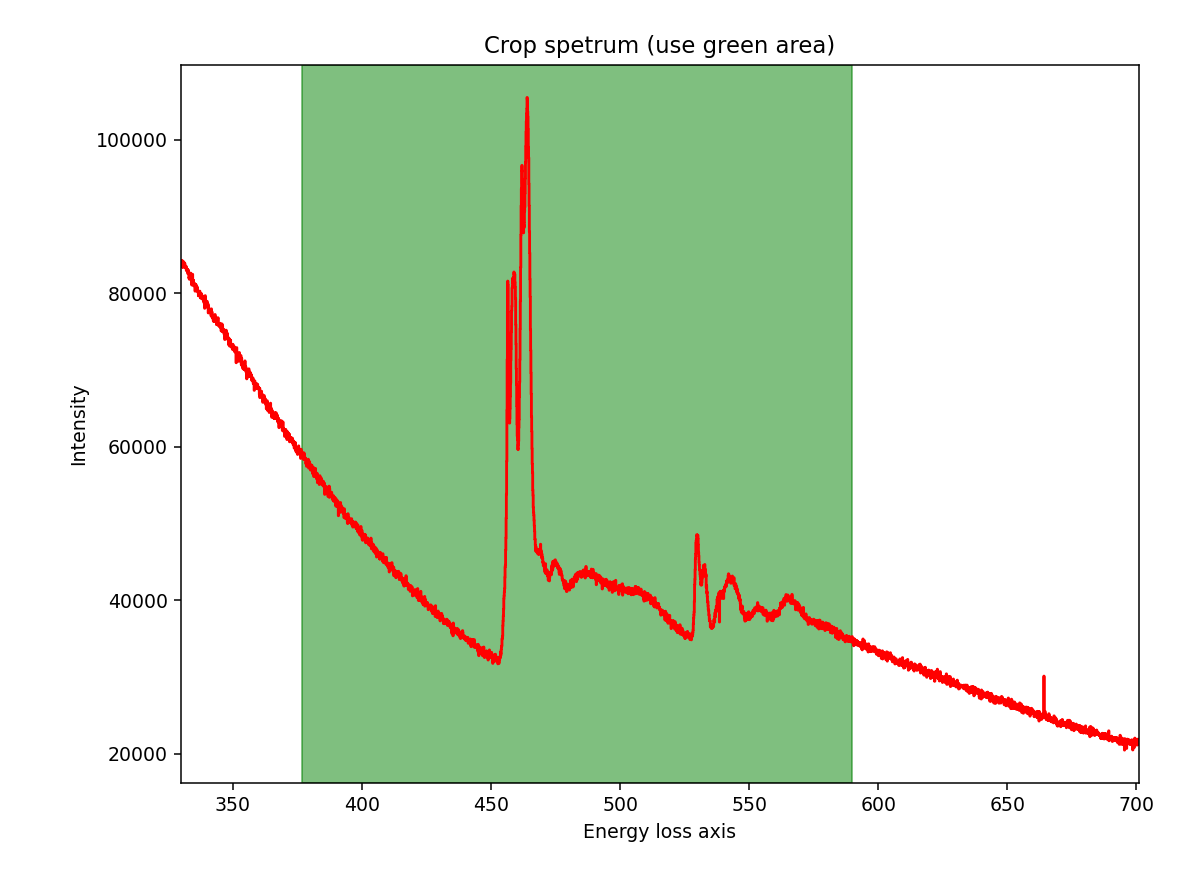

In [3]:
# Preprocess spectrum image

# Spectrum Image recorded with direct detection camera
poisson_noise = True

# Crop spectra
cropping = True


# Load spectrum image
s_EELS = hs.load(filename_EELS)
s_EELS.set_signal_type("EELS")

# Load dark field image
s_darkfield = hs.load(filename_darkfield)
s_darkfield.metadata.General.name = 'dark_field_image'

# Crop spectral axis
if cropping:
    # Average spectra --> new EELS-set
    s_crop = hs.signals.Signal1D(np.sum(s_EELS.data,axis=(0,1)))
    # Define axes manager
    s_crop.axes_manager[0].name = s_EELS.axes_manager[2].name
    s_crop.axes_manager[0].scale = s_EELS.axes_manager[2].scale
    s_crop.axes_manager[0].offset = s_EELS.axes_manager[2].offset
    # Initialize crop region
    roi_crop = hs.roi.SpanROI(left=s_crop.axes_manager[0].offset, right=s_crop.axes_manager[0].offset + 50)

    # Interactive plot
    s_crop.plot()
    plt.gca().set_title('Crop spetrum (use green area)')
    roi_crop.interactive(s_crop, color='green')

In [4]:
# Crop
if cropping:
    s_EELS.crop(2,start = roi_crop.left, end = roi_crop.right)
    print('Crop Region from ' + str(np.around(roi_crop.left,decimals = 2)) + ' eV to ' + str(np.around(roi_crop.right, decimals = 2)) + ' eV')

Crop Region from 377.0 eV to 589.9 eV


## Clustering
In this section the spectrum image is clustered to identify which areas can be used for averaging.
The following steps are:

- Decompose by PCA
- Reduce dimensionality by t-SNE
- Cluster by OPTICS
- Plotting results (Colored map, averaged spectra of same cluster)

This algorithm is from the paper, J. Ryu et al., “Dimensionality reduction and unsupervised clustering for EELS-SI,” Ultramicroscopy, p. 113314, May 2021, doi: 10.1016/J.ULTRAMIC.2021.113314.

Depending on the used number of components (n_eig), perplexity of t-SNE (perplexity_tsne) and eps at optics (eps_optics), smaller or larger clusters can be identified.

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


<IPython.core.display.Javascript object>


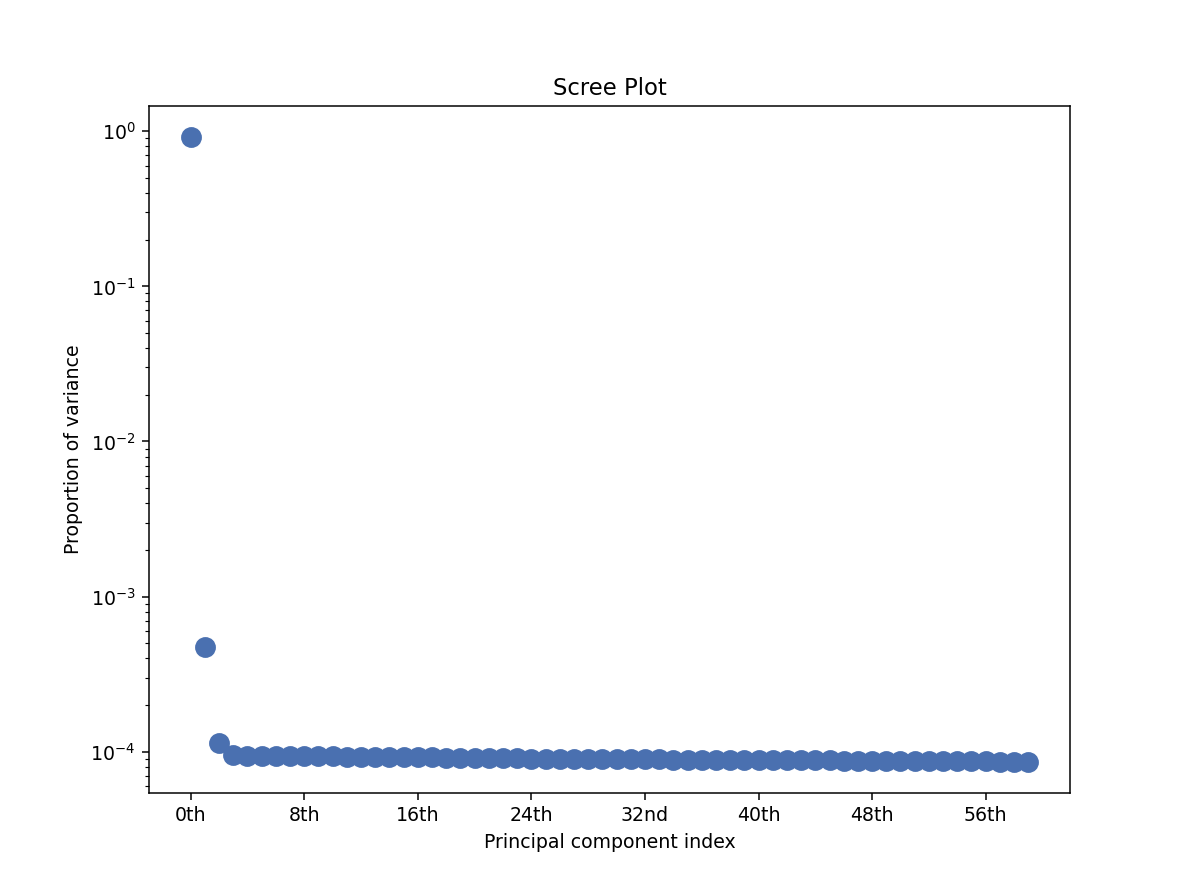

Text(0.5, 1.0, 'Scree Plot')

In [5]:
# Decompose with PCA

# No negative values are allowed for a possion distribution (Shifting spectra minimum value upwards or setting negative values to zero)
s_EELS.data -= np.amin(s_EELS.data) # Shifting the spectrum upwards or setting 0

# Decompose spectra
s_EELS.decomposition(normalize_poissonian_noise=poisson_noise)

# Plot scree plot
n_plot = 60 # Maximum plotted components
ax = s_EELS.plot_explained_variance_ratio(n=n_plot,vline=False)
ax.set_title('Scree Plot')

In [6]:
# Get number of components for reconstructing the spectra
print("Number of components for reconstruction (only used for clustering):")
n_eig = int(input())

Number of components for reconstruction (only used for clustering):
35


<IPython.core.display.Javascript object>


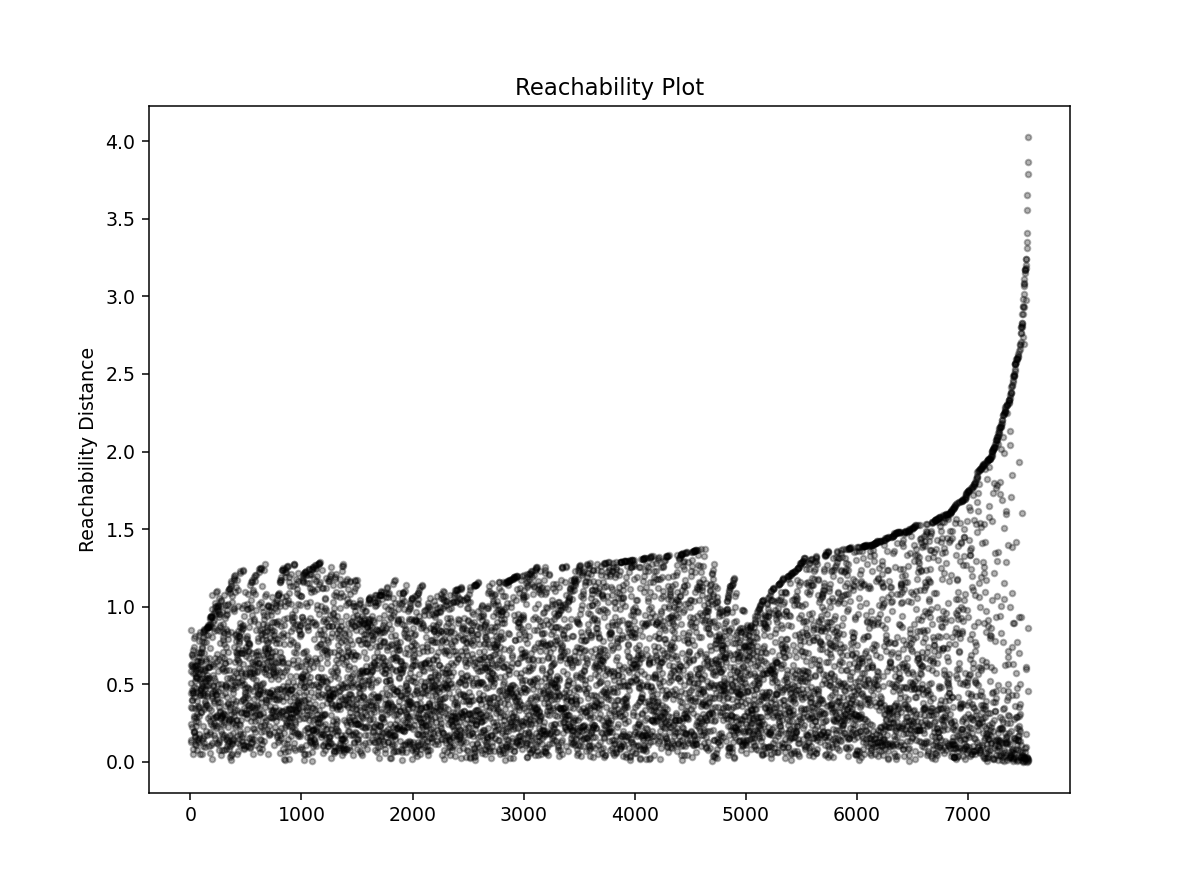

In [7]:
# Perplexity for the t-SNE algorithm (can be changed in the range of about 5 to 60)
perplexity_tsne = 30

# Extracting the factor-matrix from the hyperspy framework for further clustering
factor_matrix = s_EELS.get_decomposition_loadings()

# Select only factors, which are used for reconstruction
factor_tsne = factor_matrix.data[0:n_eig+1,:,:] 
factor_reshaped = factor_tsne.reshape(factor_tsne.data.shape[0],-1)

# Reduce dimensionality by t-sne with sklearn
tsne = TSNE(perplexity=perplexity_tsne, random_state=0, init='pca', method='barnes_hut') # method... 'excact' or ’barnes_hut’ --> faster
tsne_results = tsne.fit_transform(factor_reshaped.transpose())


# Plot the results from the OPTICS algorithm without assigning to clusters

# Numpy to Pandas Dataframe
column = []
for i in range(0,tsne_results.shape[1]):
    column = np.append(column,"tsne-"+str(i))
df = pd.DataFrame(data=tsne_results, columns=column)   

# Separation with OPTICS
optics_model = OPTICS(cluster_method = "dbscan", min_samples = 2)
optics_model.fit(df) 


# Plot reachability
plt.figure()
plt.plot(optics_model.reachability_[optics_model.ordering_], 'k.', alpha = 0.3) 
plt.ylabel('Reachability Distance') 
plt.title('Reachability Plot') 
plt.show() 

In [11]:
# Define value for clustering (can be estimated form the reachability plot)
print("Eps for clustering (extract it from reachability plot)")
eps_optics = float(input())

Eps for clustering (extract it from reachability plot)
1.2


<IPython.core.display.Javascript object>


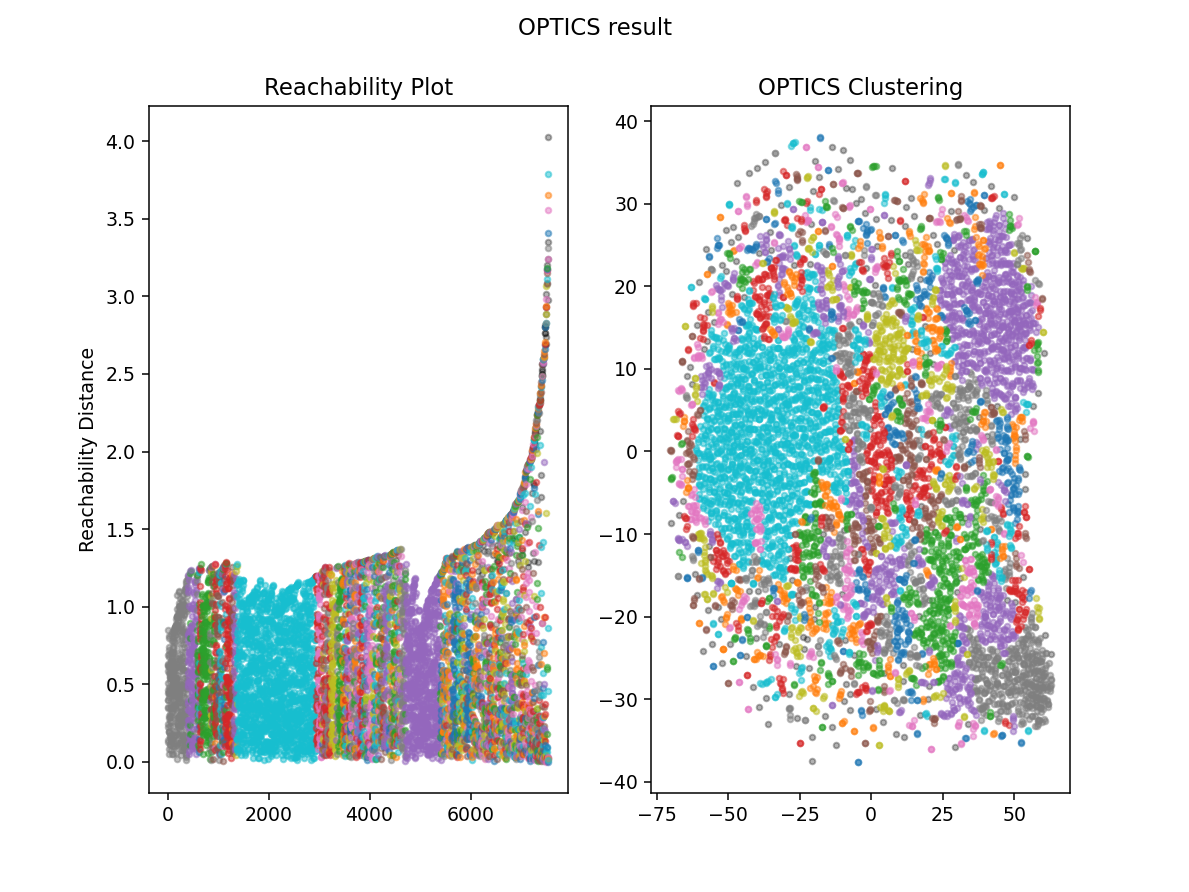

Text(0.5, 1.0, 'OPTICS Clustering')

In [12]:
# Cluster spectra with given eps
labels_eps = cluster_optics_dbscan(reachability=optics_model.reachability_,
                                   core_distances=optics_model.core_distances_,
                                   ordering=optics_model.ordering_, eps=eps_optics)

# Storing the reachability distance of each point 
reachability = optics_model.reachability_[optics_model.ordering_] 


# Creating a numpy array with numbers at equal spaces till the specified range for colouring
space = np.arange(len(df)) 
 
# Storing the cluster labels of each point 
labels = labels_eps[optics_model.ordering_]
# If smaller than 0, no clusters are found
if np.amax(labels) < 0:
    n_samples = 0
else:
    n_samples = np.amax(labels)

#Creating colors from specific color map (colormap can be changed)
cmap = plt.get_cmap('tab10', n_samples+1) # n_samples+1 to consider the no-cluster
colors = [cmap(i) for i in np.linspace(0, 1, n_samples+1)]
random.shuffle(colors) # shuffle color for better visualization
colors.insert(0,[0, 0, 0, 1.0]) # add black for the no-cluster

# Plotting results (coloured reachability and coloured t-SNE plot)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('OPTICS result')

for Class, colour  in zip(range(-1, n_samples), colors): 
    # Coloured reachability-distance plot 
    Xk_r = space[labels == Class] 
    Rk = reachability[labels == Class] 
    
    # Coloured OPTICS Clustering 
    Xk_o = df[labels_eps == Class]   

    if Class == -1:
        ax1.plot(Xk_r, Rk, color=colour, alpha = 0.3,linestyle="",marker=".")
        ax2.plot(Xk_o.iloc[:, 0], Xk_o.iloc[:, 1], color=colour, alpha = 0.3,linestyle="",marker=".")  
    else:
        ax1.plot(Xk_r, Rk, color=colour, alpha = 0.5,linestyle="",marker=".") 
        ax2.plot(Xk_o.iloc[:, 0], Xk_o.iloc[:, 1], color=colour, alpha = 0.5,linestyle="",marker=".")  

ax1.set_ylabel('Reachability Distance') 
ax1.set_title('Reachability Plot') 
     
ax2.set_title('OPTICS Clustering') 

<IPython.core.display.Javascript object>


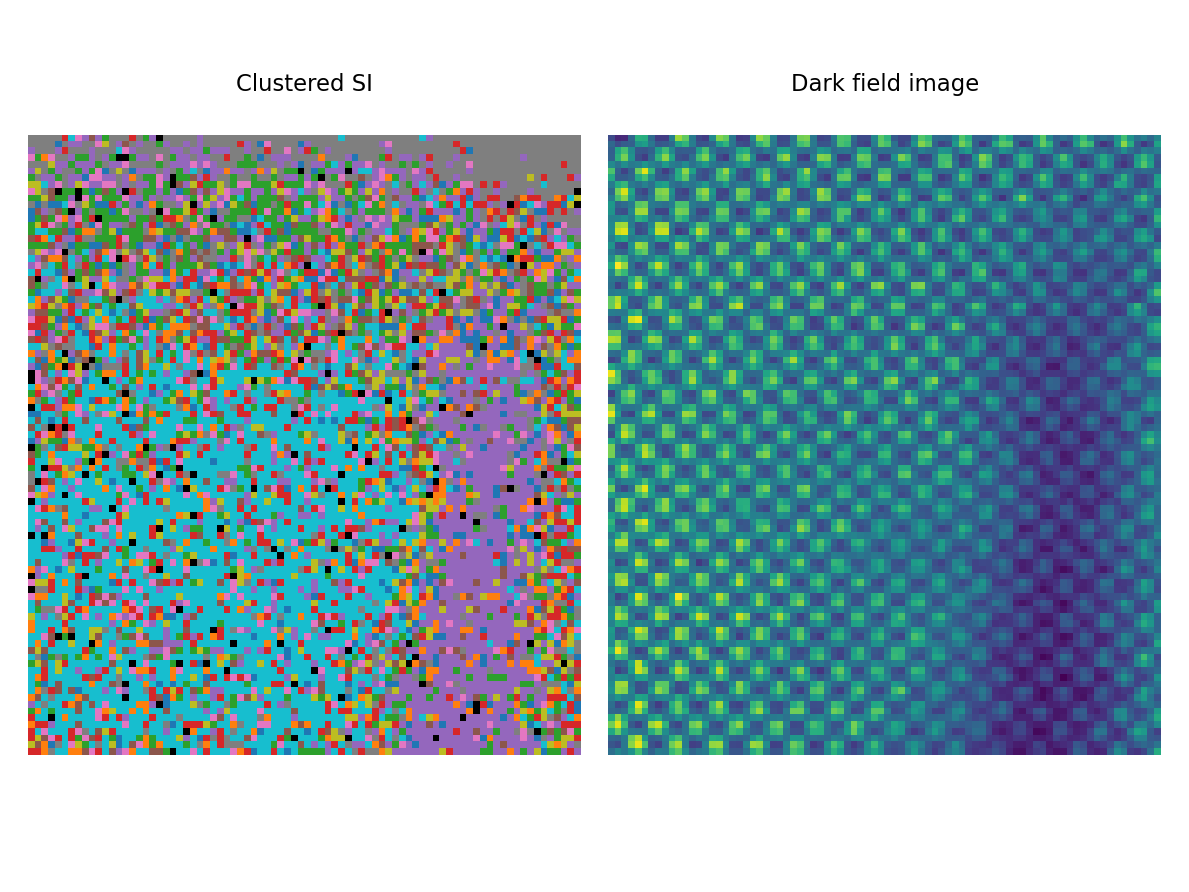

In [13]:
# Plot coloured map with corresponding color of the clustering

# Create new colormap to match the color from before
newcmp = ListedColormap(colors)

# Plotting clustered SI
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

labels_shaped = np.reshape(labels_eps, ( s_EELS.data.shape[0], s_EELS.data.shape[1]))
ax1.matshow(labels_shaped,cmap=newcmp)
ax1.axis('off')
ax1.set_title('Clustered SI')

ax2.matshow(s_darkfield.data)
ax2.axis('off')
ax2.set_title('Dark field image')

fig.tight_layout()

In [20]:
# Define how often a single cluster have to be present to be averaged
print("Enter the number, how often a cluster have to be present to be averaged")
k_points = int(input())

Enter the number, how often a cluster have to be present to be averaged
400


In [21]:
# Average over all pixels from the denoised SI by PCA
sc = s_EELS.get_decomposition_model(n_eig)
sc_averaged = np.mean(sc.data,axis=(0,1))
sc_averaged = sc_averaged[:,np.newaxis]

# Average over all pixels from the original SI
s_averaged = np.mean(s_EELS.data,axis=(0,1))
s_averaged = s_averaged[:,np.newaxis]

# First element is the over all averaged spectra in black
label_color = [-1]

# Loop over all labels
labels_unique = np.unique(labels)

for idx, label_unique in enumerate(labels_unique):
    
    # Loop only over labels, which have mor then k_points pixels and are not the no-cluster
    if len(labels[labels == label_unique]) >= k_points and label_unique != -1:
        
        # Add label to the color list
        label_color = np.append(label_color,label_unique)
        
        # Average all spectra with the same label (PCA denoised)
        sc_vec = np.reshape(sc.data, ( labels_eps.shape[0], sc.data.shape[2]))
        a = np.mean(sc_vec[labels_eps == label_unique],axis=0)
        a = a[:,np.newaxis]
        sc_averaged = np.append(sc_averaged,a,axis=1)
        
        # Average all spectra with the same label (original)
        s_vec = np.reshape(s_EELS.data, ( labels_eps.shape[0], s_EELS.data.shape[2]))
        a = np.mean(s_vec[labels_eps == label_unique],axis=0)
        a = a[:,np.newaxis]
        s_averaged = np.append(s_averaged,a,axis=1)
        
print('Number of clusters for plotting: ' + str(sc_averaged.shape[1]-1))

Number of clusters for plotting: 2


<IPython.core.display.Javascript object>


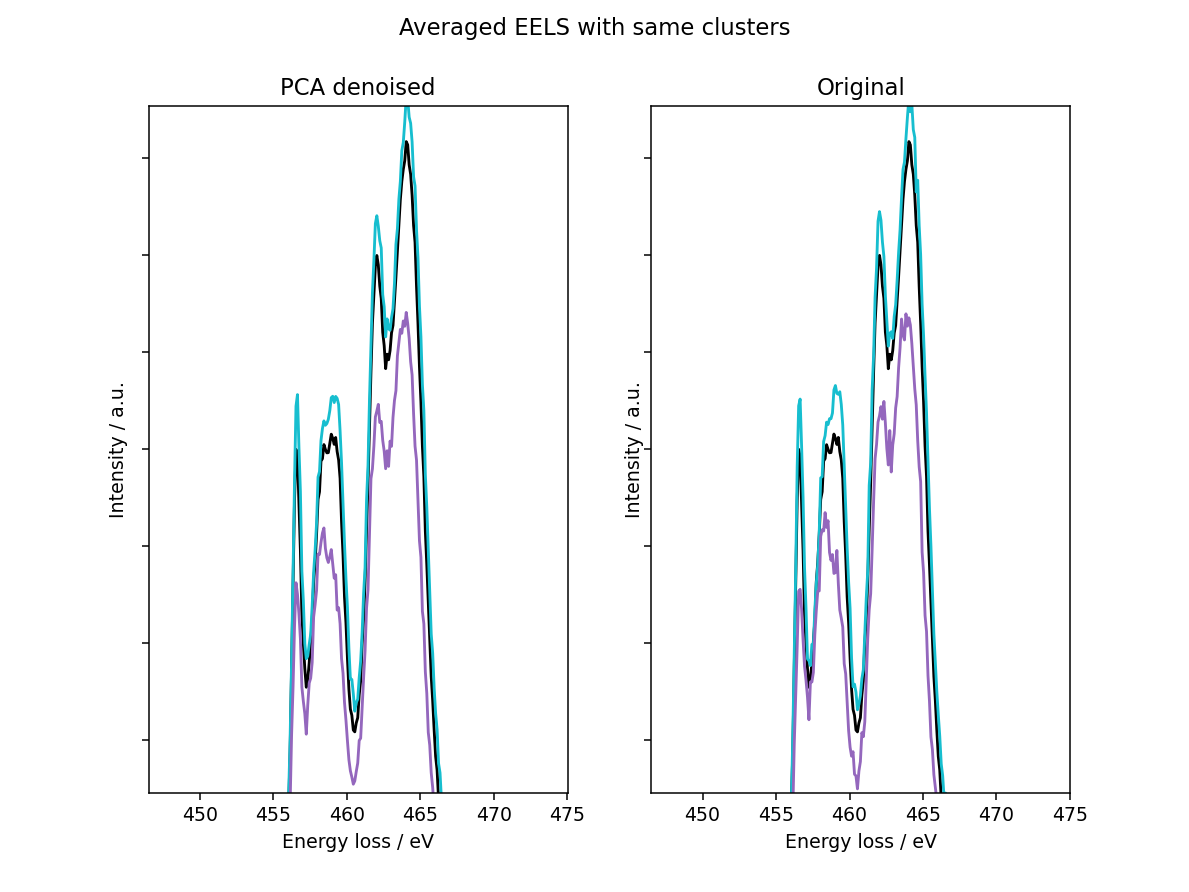

[0, 0, 0, 1.0]


Text(0, 0.5, 'Intensity / a.u.')

In [22]:
# Extract the energy axes for a correct x-axes
energy_axes = np.linspace(s_EELS.axes_manager["Energy loss"].offset,s_EELS.axes_manager["Energy loss"].offset+s_EELS.axes_manager["Energy loss"].scale*s_EELS.axes_manager["Energy loss"].size,s_EELS.axes_manager["Energy loss"].size)

# Plotting averaged spectra (black in the spectra)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Averaged EELS with same clusters')

for i in range(0,sc_averaged.shape[1]):
    # Select correct color
    if label_color[i] == -1: # aveaged spectra in black
        colour = colors[0]
        print(colour)
    else:
        colour = colors[int(label_color[i])+1]
    ax1.plot(energy_axes, sc_averaged[:,i], color = colour)
    ax2.plot(energy_axes, s_averaged[:,i], color = colour)
    
ax1.set_title('PCA denoised') 
ax1.set_xlabel('Energy loss / eV')
ax1.set_ylabel('Intensity / a.u.')
ax1.axes.yaxis.set_ticklabels([])
ax2.set_title('Original') 
ax2.set_xlabel('Energy loss / eV')
ax2.set_ylabel('Intensity / a.u.')

## Determining atom position - drift correction
In this section the atom postions are determined from the reference image. With the known positions, linear drift correction is applied and the atom position are used as center for each slice, which are cropped from the original image.

In [27]:
# Set lower separation range
print("Lower separation range of two atoms in pixels")
s_low = int(input())

Lower separation range of two atoms in pixels
1


<IPython.core.display.Javascript object>


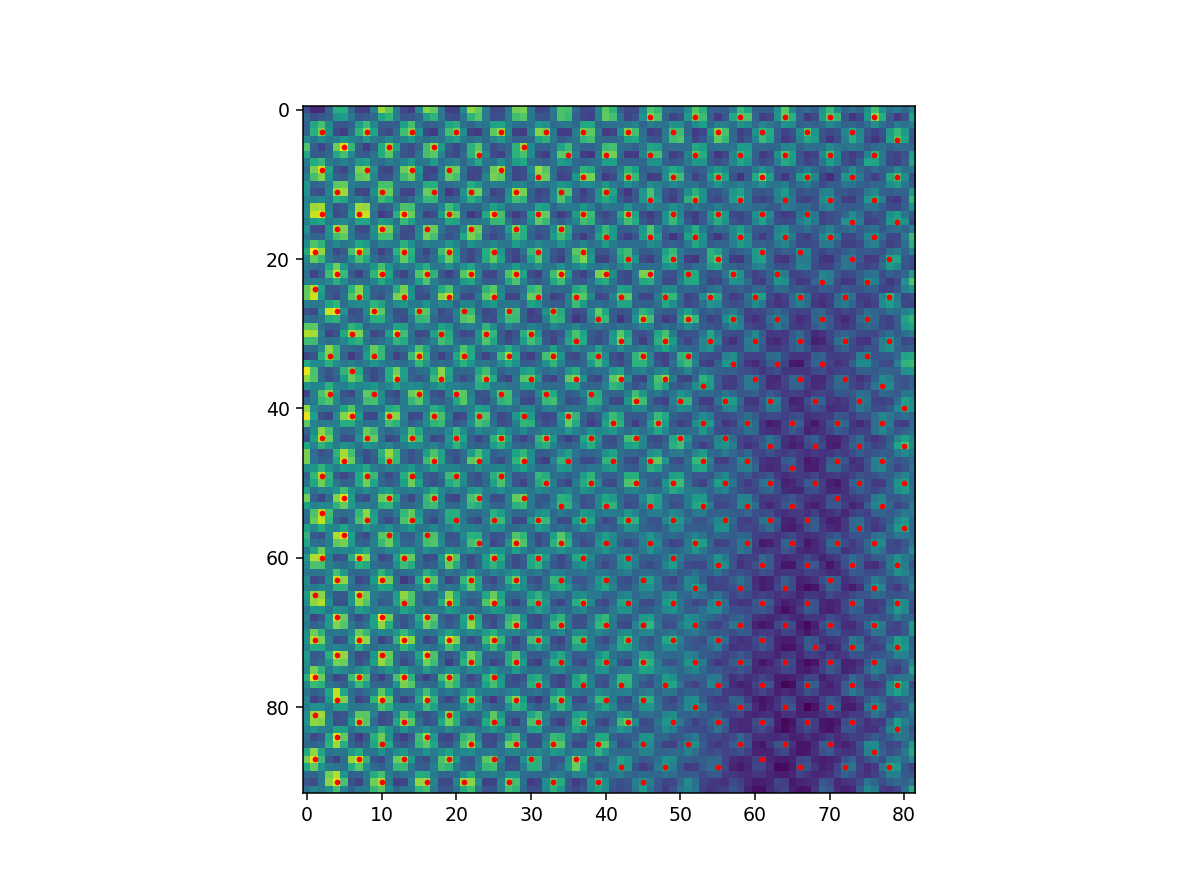

In [28]:
# Get atom position
atom_positions = am.get_atom_positions(s_darkfield, separation=s_low, pca=True, subtract_background=True)

# Plot darkfield with atom positions
plt.figure()
plt.imshow(s_darkfield.data)
plt.scatter(atom_positions[:,0],atom_positions[:,1], c='r', s=4)

In the following plot, atom position can be removed. These remaining atom position will be used for the drift correction, therefore should be only from one lattice. Individual atoms can be removed/added later.

<IPython.core.display.Javascript object>


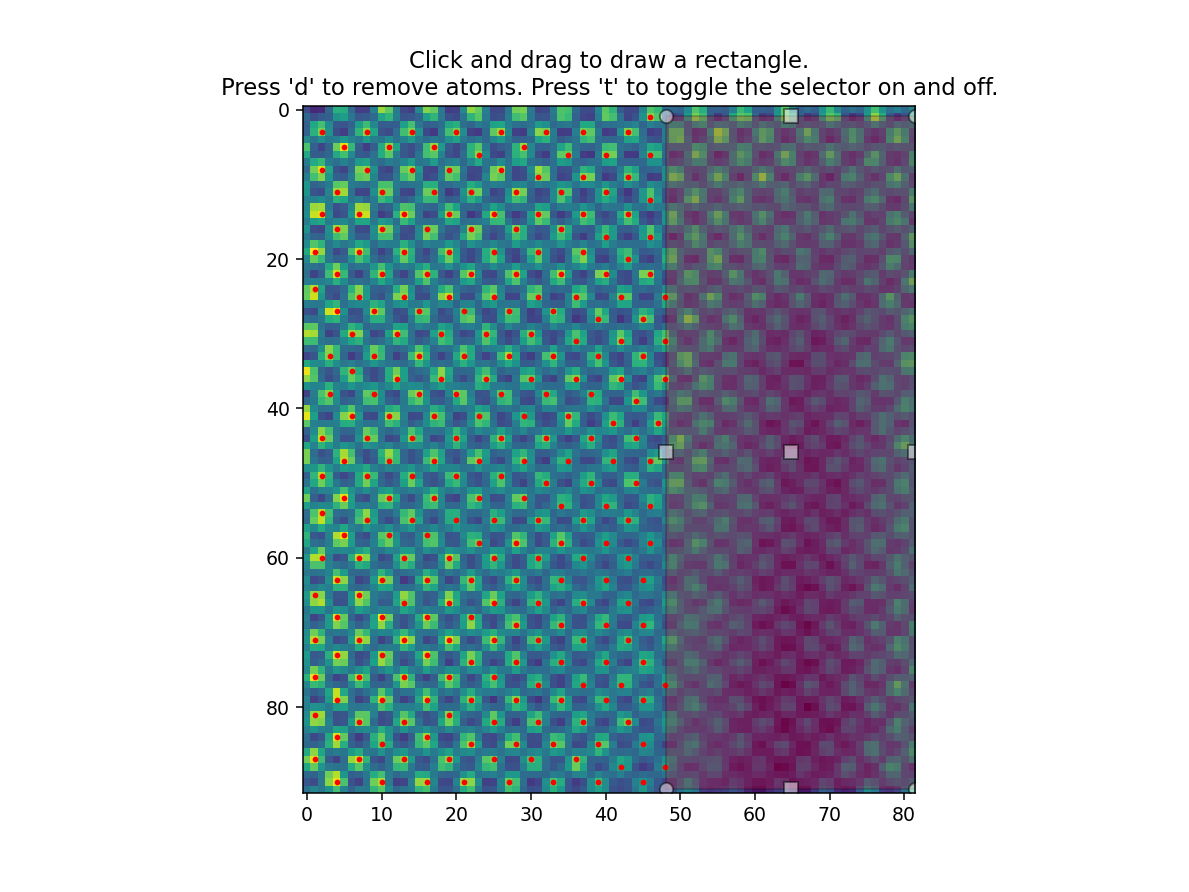

In [29]:
# Remove atoms from larger areas by interactive plotting (especially for interfaces to exclude one side) 

def line_select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    global x1, y1, x2, y2
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print(f"({x1:3.2f}, {y1:3.2f}) --> ({x2:3.2f}, {y2:3.2f})")
    print(f" The buttons you used were: {eclick.button} {erelease.button}")
    
    return

def toggle_selector(event):
    global atom_positions
    global scatter_atom
    print(' Key pressed.')
    if event.key == 't':
        if toggle_selector.RS.active:
            print(' RectangleSelector deactivated.')
            toggle_selector.RS.set_active(False)
        else:
            print(' RectangleSelector activated.')
            toggle_selector.RS.set_active(True)
    if event.key == 'd':
        index = []
        for i, position in enumerate(atom_positions):
            if (position[0] >= x1 and position[0] <= x2 and position[1] >= y1 and position[1] <= y2):
                index.append(i)
        atom_positions = np.delete(atom_positions,index, axis=0)
        scatter_atom.set_offsets(np.c_[atom_positions[:,0],atom_positions[:,1]])
        fig.canvas.draw_idle()
    return
        
            
            
fig, ax = plt.subplots()

ax.imshow(s_darkfield.data)
scatter_atom = ax.scatter(atom_positions[:,0],atom_positions[:,1], c='r', s=4)
ax.set_title(
    "Click and drag to draw a rectangle.\n"
    "Press 'd' to remove atoms. "
    "Press 't' to toggle the selector on and off.")

# drawtype is 'box' or 'line' or 'none'
toggle_selector.RS = RectangleSelector(ax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # disable middle button
                                       minspanx=2, minspany=2,
                                       spancoords='pixels',
                                       interactive=True)
fig.canvas.mpl_connect('key_press_event', toggle_selector)
plt.show()            

By clicking, individual atoms can be removed/added. After finishing, you have to close the image!

<IPython.core.display.Javascript object>


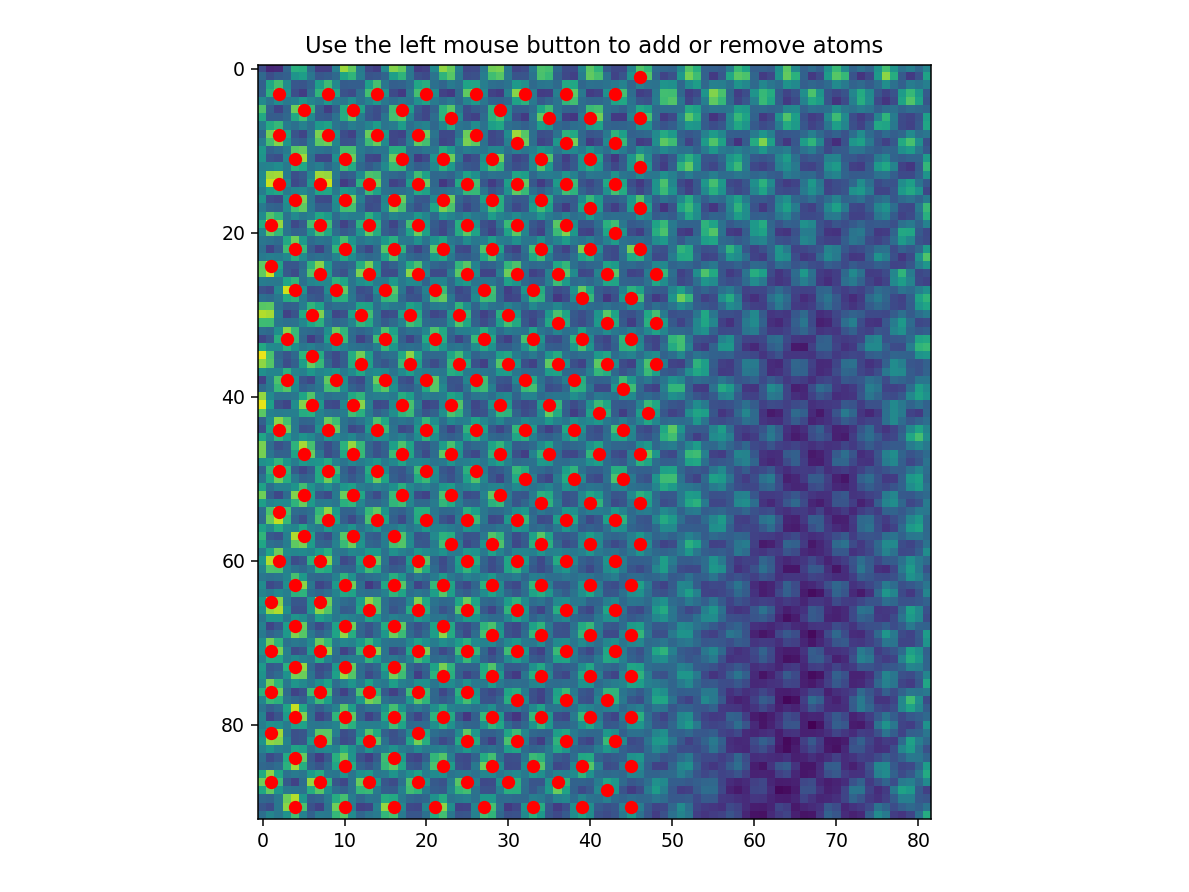

In [31]:
# Add or remove indvidual atoms - close window if you finished
atom_positions = am.add_atoms_with_gui(s_darkfield, atom_positions,distance_threshold=s_low)

Center of mass:   0%|          | 0/266 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/266 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


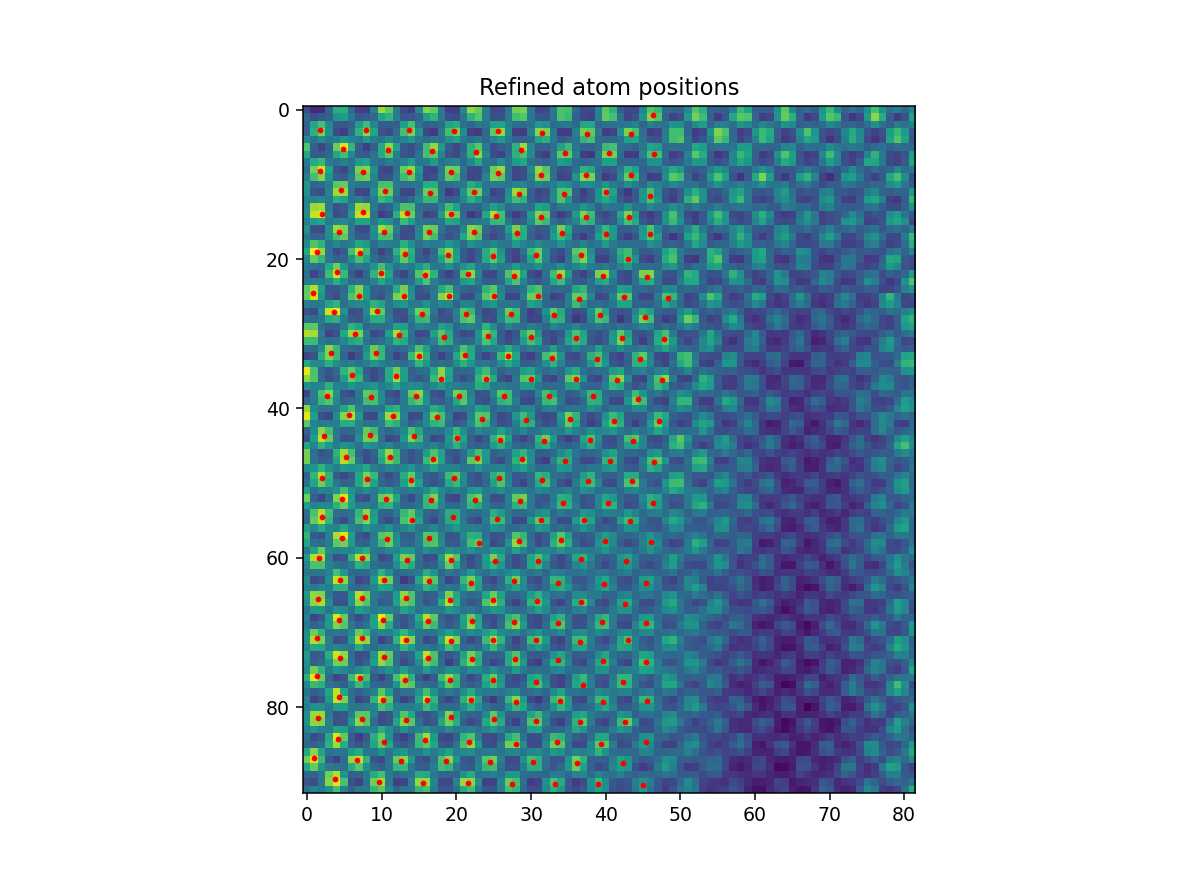

Text(0.5, 1.0, 'Refined atom positions')

In [32]:
# Refine atom position by center of mass and 2d gaussians
sublattice_A = am.Sublattice(atom_positions, image=s_darkfield.data, color='r')
sublattice_A.find_nearest_neighbors()
sublattice_A.refine_atom_positions_using_center_of_mass()
sublattice_A.refine_atom_positions_using_2d_gaussian() # Warnings can be ignored

# Generate atom lattice
atom_lattice = am.Atom_Lattice(image=s_darkfield.data, sublattice_list=[sublattice_A])

# Plot refined atom positions

# Get atom positions for plotting
x_px_plot = atom_lattice.x_position
y_px_plot = atom_lattice.y_position

fig, ax = plt.subplots()
ax.imshow(s_darkfield.data)
scatter_atom = ax.scatter(x_px_plot,y_px_plot, c='r', s=4)
plt.title('Refined atom positions')

<IPython.core.display.Javascript object>


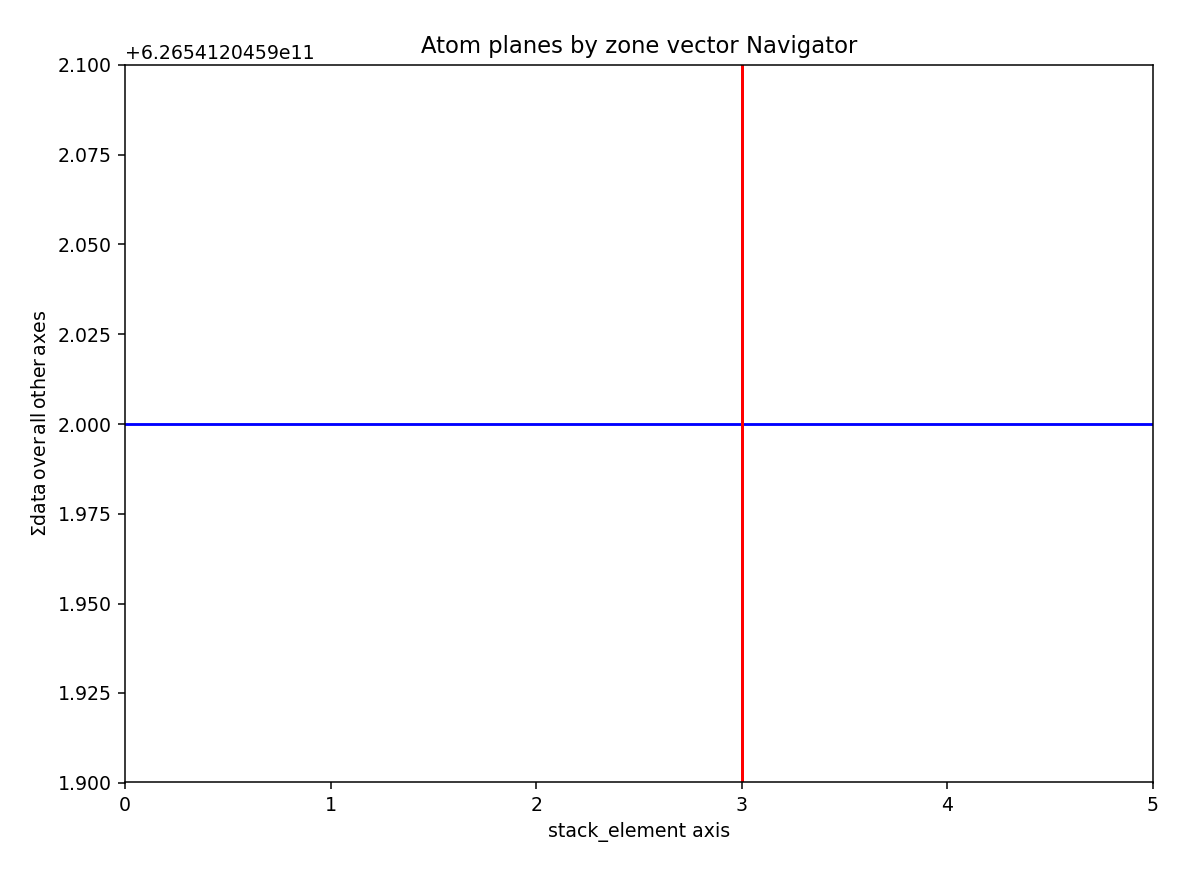

<IPython.core.display.Javascript object>


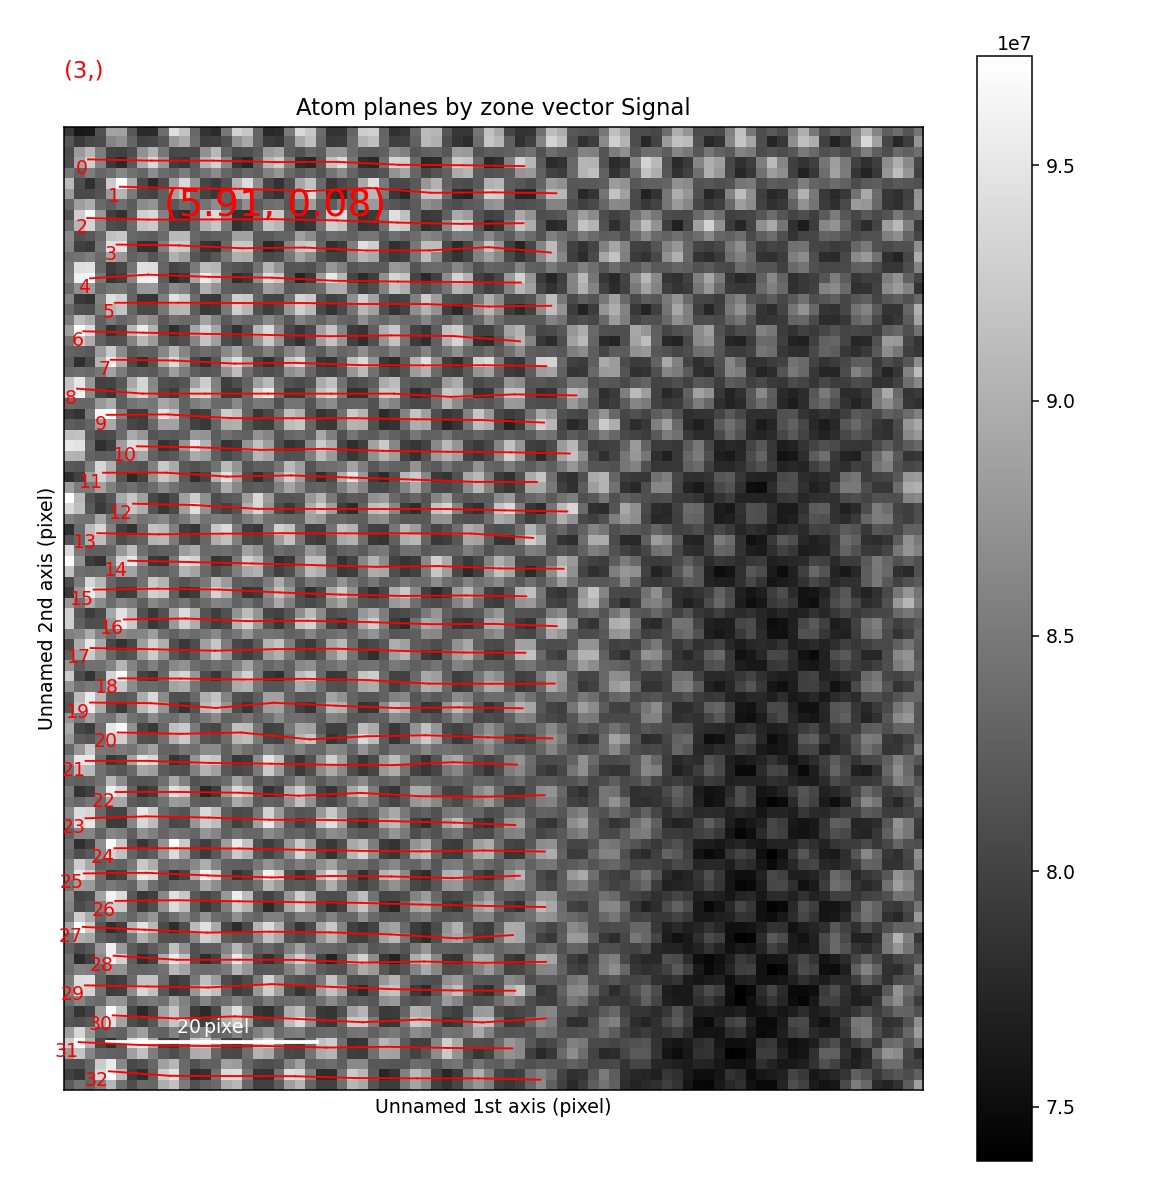

In [33]:
# Construct planes and navigated through it
sublattice_A.construct_zone_axes()
sublattice_A.plot_planes()

In [34]:
# Define from plot above, which indexes have the horizontal plane and the vertical plane
print("X - (Horizontal) Planes Index: ")
lattice_h = int(input())
print("Y - (Vertical) Planes Index: ")
lattice_v = int(input())

X - (Horizontal) Planes Index: 
3
Y - (Vertical) Planes Index: 
2


<IPython.core.display.Javascript object>


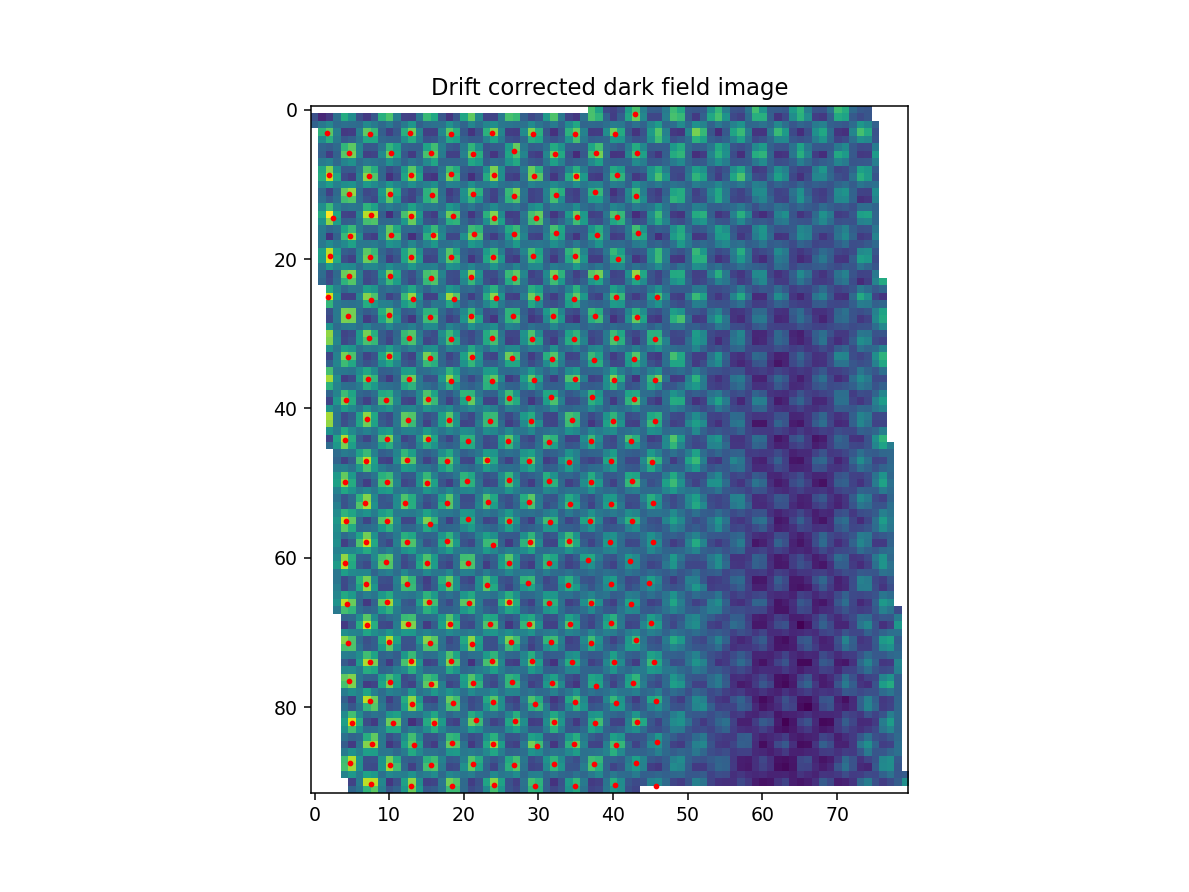

Text(0.5, 1.0, 'Drift corrected dark field image')

In [35]:
# Projected crystal vectors
crystal_x = [1,0] # Crystal-Vector in x direction (horizontal-aligned)
crystal_y = [0,1] # Crystal-Vector in y direction (vertical)

# Calculate crystal vectors
measured_x = sublattice_A.zones_axis_average_distances[lattice_h]
measured_y = sublattice_A.zones_axis_average_distances[lattice_v]

# Get dark field image and spectrum image as numpy array
dark_field_image = s_darkfield.data[:,:,np.newaxis]
EELS_data = s_EELS.data
labels_shaped_3d = labels_shaped[:,:,np.newaxis]

# Transform atom position from atomap
x_px_A = sublattice_A.x_position
y_px_A = sublattice_A.y_position
atom_position_a = np.transpose(np.column_stack((x_px_A,y_px_A)))

# Transformation matrix
def transform_matrix(rotation = 0, shear = 0, sx = 1, sy = 1, corr = False):
    
    # correction term due to shear
    if corr:
        x_corr = math.cos(rotation) / math.cos(rotation + shear)
    else:
        x_corr = 1

    matrix = np.array([
    [x_corr * sx * math.cos(rotation + shear), -sy * math.sin(rotation), 0],
    [x_corr * sx * math.sin(rotation + shear),  x_corr * sy * math.cos(rotation), 0],
    [                      0,                                0, 1]
    ])
    
    return matrix


# Calculate angle for crystal_x to horizontal
theta_crystal = -np.arccos(np.dot([1,0], crystal_x)/np.linalg.norm(crystal_x))

# Calculate angle for measured_x to crystal_x
theta_measured = -np.arccos(np.dot(crystal_x, measured_x)/(np.linalg.norm(crystal_x)*np.linalg.norm(measured_x)))
rotation_angle = theta_crystal + theta_measured

# Calculate shear for measured_y to crystal_y_rot
shear_delta = -np.arccos(np.dot(measured_y, crystal_y)/(np.linalg.norm(measured_y)*np.linalg.norm(crystal_y)))
shear_angle = shear_delta - theta_measured

# Shear does not keep length?
transformation_vec = transform_matrix(rotation = 0, shear = shear_angle, sx = 1, sy = 1)
measured_x_shear = np.array(measured_x).dot(transformation_vec[0:2,0:2])
measured_y_shear = np.array(measured_y).dot(transformation_vec[0:2,0:2])

# Calculate stretch in y-vector (corrected in x-axis)
ratio = np.linalg.norm(crystal_y)/np.linalg.norm(crystal_x)*(np.linalg.norm(measured_x_shear)/np.linalg.norm(measured_y_shear))
# Only stretch smaller axis, other axis is not scaled
crystal_xnorm = np.linalg.norm(crystal_x)
crystal_ynorm = np.linalg.norm(crystal_y)
if ratio > 1:
    sy = (crystal_x[0]/crystal_xnorm + crystal_y[0]/crystal_ynorm)*ratio
    sx = 1
elif ratio < 1:
    sx = (crystal_x[1]/crystal_xnorm + crystal_y[1]/crystal_ynorm)/ratio
    sy = 1
else:
    sx = 1
    sy = 1

# Calculate transformation matrix
transformation_matrix = transform_matrix(rotation_angle, shear_angle, sx, sy, corr = False)

# Calculate dimension of the new image
a = np.ceil(np.matmul(transformation_matrix.T[0:2,0:2],np.array((dark_field_image.shape[0],0)))).astype(np.int32)
b = np.ceil(np.matmul(transformation_matrix.T[0:2,0:2],np.array((0,dark_field_image.shape[1])))).astype(np.int32)
c = np.abs(a) + np.abs(b)
dim_new = np.array((c[0], c[1], dark_field_image.shape[2]))

# Define offset for the transformation
offset = (0.5*dark_field_image.shape[0], 0.5*dark_field_image.shape[1], dark_field_image.shape[2]) - dim_new.dot(transformation_matrix.T)

# Transform images
dark_field_image_trans = scipy.ndimage.affine_transform(dark_field_image, transformation_matrix, offset=offset, output_shape=(int(2*dim_new[0]),int(2*dim_new[1]),dim_new[2]), output=None, order=3, mode='constant', cval=np.NaN, prefilter=True)
EELS_data = scipy.ndimage.affine_transform(EELS_data, transformation_matrix, offset=offset, output_shape=(int(2*dim_new[0]),int(2*dim_new[1]),EELS_data.shape[2]), output=None, order=3, mode='constant', cval=np.NaN, prefilter=True)
labels_shaped_transformed = scipy.ndimage.affine_transform(labels_shaped_3d.astype(float), transformation_matrix, offset=offset, output_shape=(int(2*dim_new[0]),int(2*dim_new[1]),labels_shaped_3d.shape[2]), output=None, order=0, mode='constant', cval=np.NaN, prefilter=True)


# Identify the translation required for the atom positions
for i in range(0,dark_field_image_trans.shape[0]):
    k_y = i
    if ~np.isnan(dark_field_image_trans[i,:]).all(axis=(0,1)):
        break
for i in range(0,dark_field_image_trans.shape[1]):
    k_x = i
    if ~np.isnan(dark_field_image_trans[:,i]).all(axis=(0,1)):
        break

# Remove nan-margin        
dark_field_image_trans = dark_field_image_trans[:, ~np.isnan(dark_field_image_trans).all(axis=(0,2))]
dark_field_image = dark_field_image_trans[~np.isnan(dark_field_image_trans).all(axis=(1,2)),:]   

EELS_data = EELS_data[:, ~np.isnan(EELS_data).all(axis=(0,2))]
EELS_data = EELS_data[~np.isnan(EELS_data).all(axis=(1,2)),:]   

labels_shaped_transformed = labels_shaped_transformed[:, ~np.isnan(labels_shaped_transformed).all(axis=(0,2))]
labels_shaped_transformed = labels_shaped_transformed[~np.isnan(labels_shaped_transformed).all(axis=(1,2)),:]   
 
# 3D points (affine transformation)
atom_position_a = np.r_[ atom_position_a, np.ones(atom_position_a.shape[1])[np.newaxis,:] ]

# Transformation matrix for points
transformation_matrix_pts = transform_matrix(-rotation_angle, -shear_angle, 1/sy, 1/sx, corr = True)

# Use same offset as at the image trasnformation --> add it to the points
atom_position_a = atom_position_a + np.tile(np.array([-offset[1], -offset[0], 0])[:,np.newaxis],(1,atom_position_a.shape[1]))

# Transform
atom_position_a_transformed = np.matmul(transformation_matrix_pts.T, atom_position_a)

# 2D points
atom_position_a_transformed = atom_position_a_transformed[0:2,:]

# Remove same margin as at the image
atom_position_a_transformed = atom_position_a_transformed - np.tile(np.array([k_x, k_y])[:,np.newaxis],(1,atom_position_a_transformed.shape[1]))
atom_position_a_transformed = np.swapaxes(atom_position_a_transformed,0,1)

dark_field_image = dark_field_image[:,:,0]
labels_shaped_transformed = labels_shaped_transformed[:,:,0]


# Plot drift corrected images
plt.figure()
plt.imshow(dark_field_image)
plt.scatter(atom_position_a_transformed[:,0],atom_position_a_transformed[:,1], c='r', s=4)
plt.title('Drift corrected dark field image')

## Determining atom position for cropping and stacking

Leave atoms, which should be used as center for the multi-frame averaging. Indivudal atoms can be added/removed latter.

<IPython.core.display.Javascript object>


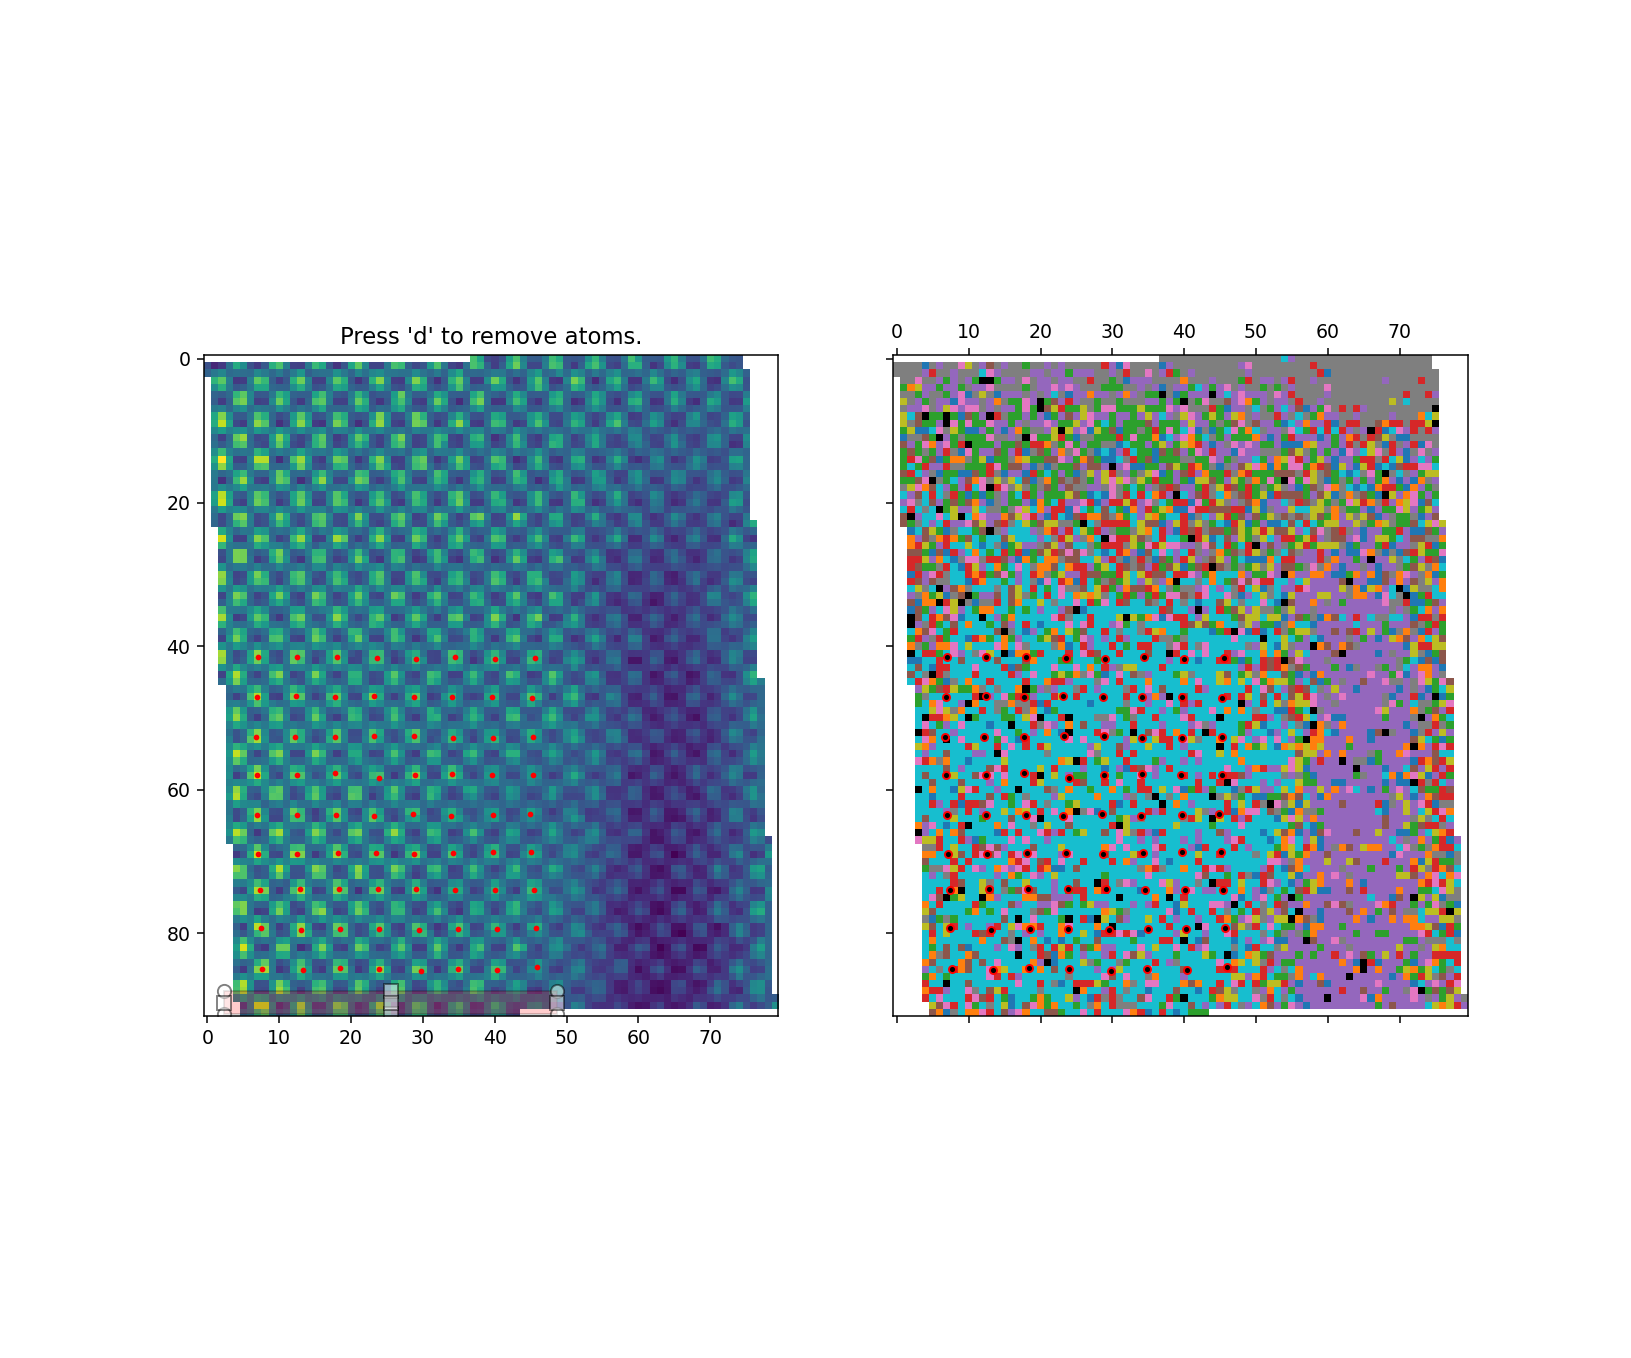

In [36]:
# Select atoms, which should be used for center of cropping
def toggle_selector(event):
    global atom_position_a_transformed
    global scatter_atom_1
    print(' Key pressed.')
    if event.key == 't':
        if toggle_selector.RS.active:
            print(' RectangleSelector deactivated.')
            toggle_selector.RS.set_active(False)
        else:
            print(' RectangleSelector activated.')
            toggle_selector.RS.set_active(True)
    if event.key == 'd':
        index = []
        for i, position in enumerate(atom_position_a_transformed):
            if (position[0] >= x1 and position[0] <= x2 and position[1] >= y1 and position[1] <= y2):
                index.append(i)
        atom_position_a_transformed = np.delete(atom_position_a_transformed,index, axis=0)
        scatter_atom_1.set_offsets(np.c_[atom_position_a_transformed[:,0],atom_position_a_transformed[:,1]])
        scatter_atom_2.set_offsets(np.c_[atom_position_a_transformed[:,0],atom_position_a_transformed[:,1]])
        fig.canvas.draw_idle()
    return
        
            
            
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

ax1.imshow(dark_field_image)
scatter_atom_1 = ax1.scatter(atom_position_a_transformed[:,0],atom_position_a_transformed[:,1], c='r', s=4)
ax1.set_title("Press 'd' to remove atoms.")

# Plot drift corrected clustered image
ax2.matshow(labels_shaped_transformed,cmap=newcmp)
scatter_atom_2 = ax2.scatter(atom_position_a_transformed[:,0],atom_position_a_transformed[:,1], c='k', edgecolors = 'r', s=14)

# drawtype is 'box' or 'line' or 'none'
toggle_selector.RS = RectangleSelector(ax1, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # disable middle button
                                       minspanx=2, minspany=2,
                                       spancoords='pixels',
                                       interactive=True)
fig.canvas.mpl_connect('key_press_event', toggle_selector)
plt.show()

Add/Remove individual atoms for the multi-frame averaging.

<IPython.core.display.Javascript object>


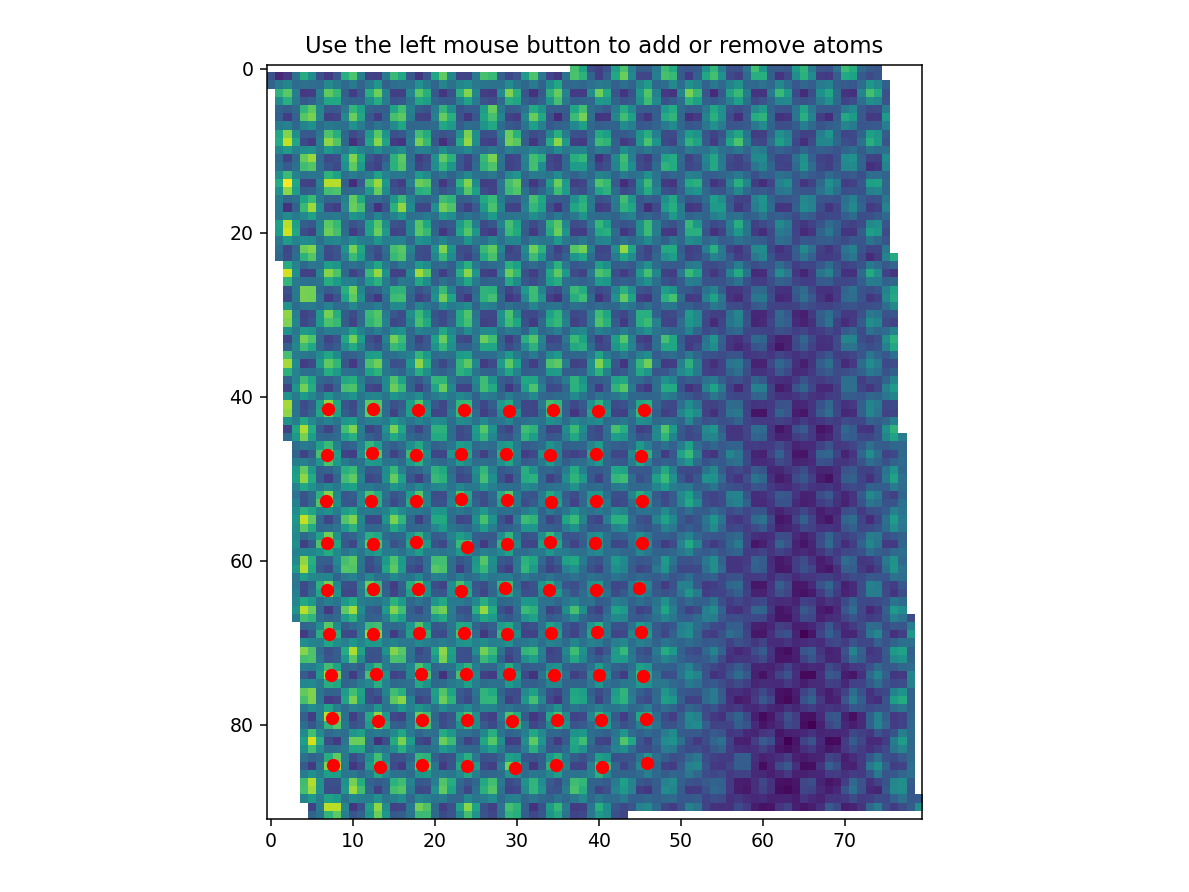

In [37]:
# Add or remove indvidual atoms - close window if you finished
atom_position_a_transformed = am.add_atoms_with_gui(dark_field_image, atom_position_a_transformed,distance_threshold=s_low)

In the following cells are cropped out of the original image and then they are stacked.

In [40]:
print("Enter the width of the cropping cells in pixels (only even numbers)")
width = int(input())
print("Enter the height of the cropping cells in pixels (only even numbers)")
height = int(input())

Enter the width of the cropping cells in pixels (only even numbers)
30
Enter the height of the cropping cells in pixels (only even numbers)
30


<IPython.core.display.Javascript object>


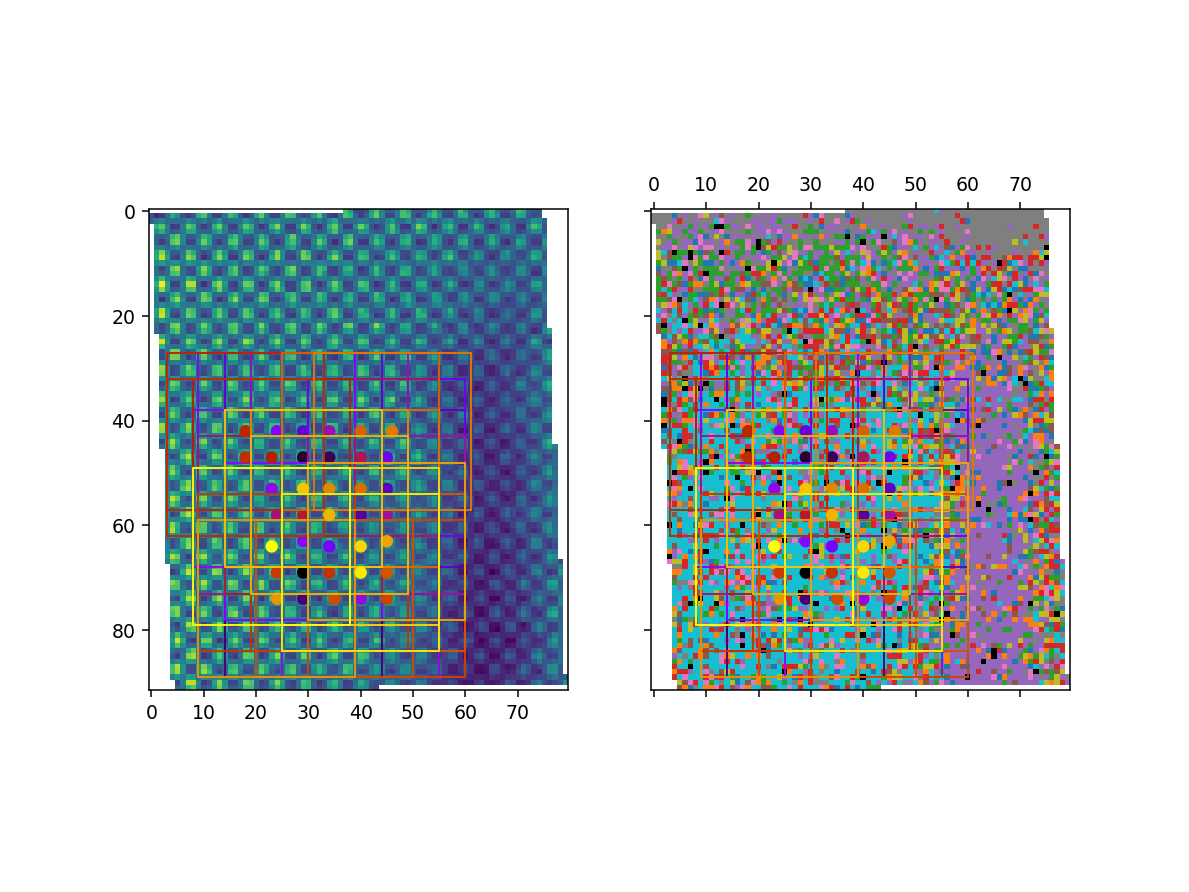

Number of cells: 37


In [41]:
# Shuffle the stacks (better alignment with SmartAlign)
shuffle = 1 

# Get shapes
image_dim = np.shape(dark_field_image)

# Get pixel
x_px = np.round(np.array(atom_position_a_transformed)[:,0])
y_px = np.round(np.array(atom_position_a_transformed)[:,1])


# Check if every atom can be cropped with the given width and height. If not, the atoms are excluded
del_px = []
for i in range(0,len(x_px)):
    
    x_low = int(x_px[i]-width/2)
    x_high = int(x_px[i]+width/2)
    y_low = int(y_px[i]-height/2)
    y_high = int(y_px[i]+height/2)  
    
    # Atoms too close to the border are removed
    if x_px[i] + width/2 >= image_dim[1] or x_px[i] - width/2 < 0:
        del_px.append(i)
    elif y_px[i] + height/2 >= image_dim[0] or y_px[i] - height/2 < 0:
        del_px.append(i)
    elif np.isnan(np.sum(dark_field_image[y_low:y_high+1, x_low:x_high+1])) == True:
        del_px.append(i)

# Atoms, which can be used for cropping
x_px_within_image = np.delete(x_px,del_px,0)
y_px_within_image = np.delete(y_px,del_px,0)

# Random vector for shuffling
if shuffle == 1:
    arr_shuffle = np.arange(len(x_px_within_image))
    np.random.shuffle(arr_shuffle) 

    x_px_within_image = x_px_within_image[arr_shuffle]
    y_px_within_image = y_px_within_image[arr_shuffle]


# Different color for each rectangles
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(y_px_within_image))]
if shuffle == 1:
    colors = [colors[i] for i in range(0, len(y_px_within_image))]

    
# Create empty stacks for dark field image and the cropping positions
dark_field_stack = np.zeros([height, width, len(y_px_within_image)])
index_image_stack = []

# Cropping rectangulars from the dark field image and stack them & plot dark field image incl the cells
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
ax1.imshow(dark_field_image)
ax2.matshow(labels_shaped_transformed,cmap=newcmp)

for i in range(0, len(y_px_within_image)):
    # Defining boundaries of the cells
    x_low = int(x_px_within_image[i]-width/2)
    x_high = int(x_px_within_image[i]+width/2)
    y_low = int(y_px_within_image[i]-height/2)
    y_high = int(y_px_within_image[i]+height/2)

    # Adding cells
    dark_field_stack[:,:,i] = dark_field_image[y_low:y_high, x_low:x_high]
    index_image_stack.append([y_low, x_low])

    # Plotting results
    
    # Create patches
    rect1 = patches.Rectangle((x_low,y_low),width,height,linewidth=1,edgecolor=colors[i],facecolor='none')
    point1 = patches.Circle((x_px_within_image[i],y_px_within_image[i]),1,linewidth=1,edgecolor=colors[i],facecolor=colors[i])
    rect2 = patches.Rectangle((x_low,y_low),width,height,linewidth=1,edgecolor=colors[i],facecolor='none')
    point2 = patches.Circle((x_px_within_image[i],y_px_within_image[i]),1,linewidth=1,edgecolor=colors[i],facecolor=colors[i])
    
    # Add the patch to the Axes
    ax1.add_patch(rect1)
    ax1.add_patch(point1)
    
    ax2.add_patch(rect2)
    ax2.add_patch(point2)    
    
print('Number of cells: ' + str(len(y_px_within_image)))

## Aligning
The stacked reference images will be aligned by SmartAlign. SmartAlign is only on Matlab available. Therefore the matlab engine will be started automatically and run SmartAlign.

Matlab asks to select two files. First choose '0_Darkfield_stack.mat' and as second '1_Index_stack.mat'.


Paper to SmartAlign: 

L. Jones et al., “Smart Align—a new tool for robust non-rigid registration of scanning microscope data,” Adv. Struct. Chem. Imaging, vol. 1, no. 1, p. 8, 2015, doi: 10.1186/s40679-015-0008-4.

<IPython.core.display.Javascript object>


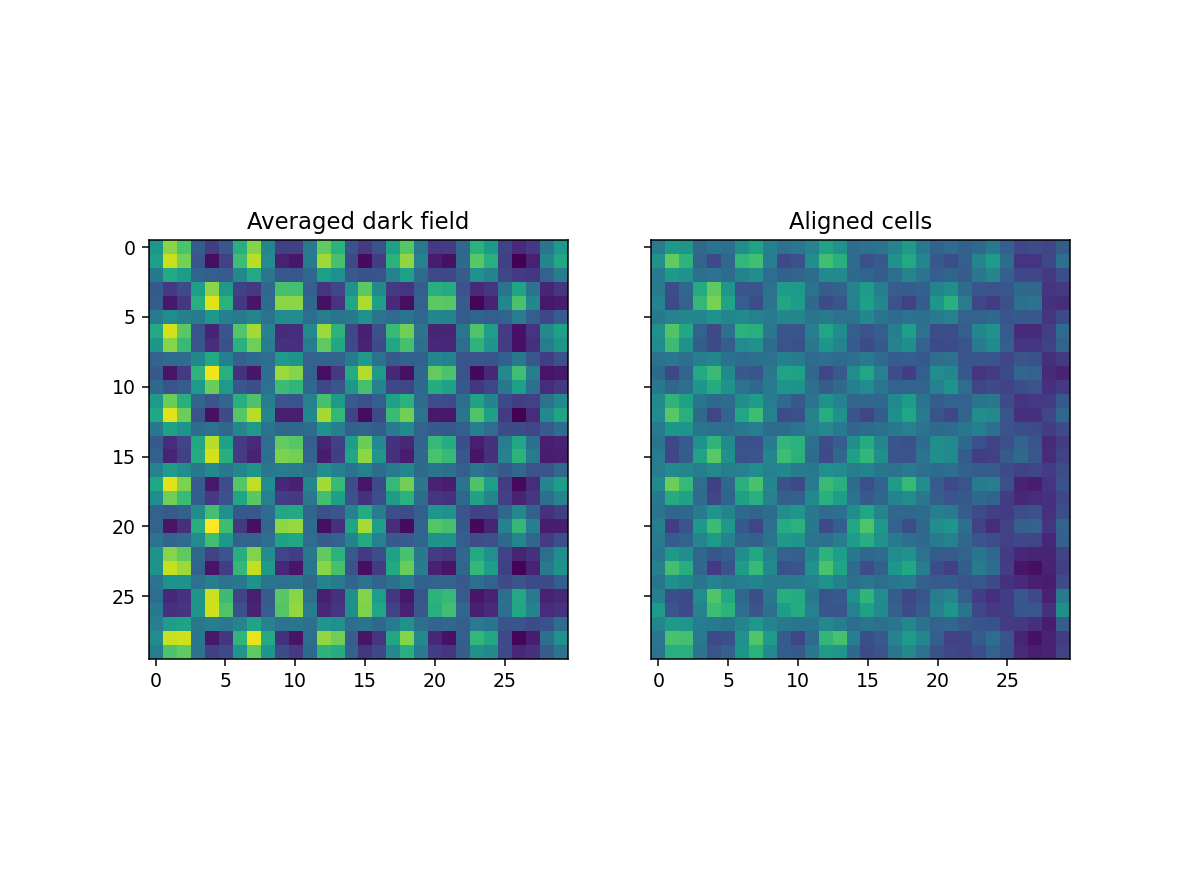

In [42]:
# Create stack for smart align second signal (save translation matrix)
index_sa = np.ones(dark_field_stack.shape).astype(int)

# Save numpy array for Matlab
scipy.io.savemat('.\\matlab\\Matlab_files\\0_Darkfield_stack.mat', {'input_file': dark_field_stack})
scipy.io.savemat('.\\matlab\\Matlab_files\\1_Index_stack.mat', {'input_file': index_sa})


# Start engine
eng = matlab.engine.start_matlab()
# Select path, where SmartAlign is saved
eng.cd(r'.\\matlab', nargout=0)
eng.ls(nargout=0)

# Load values of stack to matlab workspace
eng.workspace['number_stacks'] = dark_field_stack.shape[2]
eng.workspace['number_pixels'] = dark_field_stack.shape[0]*dark_field_stack.shape[1]


# Run SmartAlign
eng.SmartAlign_Wrapper_1_6(nargout=0)

# Extract values from matlab workspace
# Aligned darkfield stack
darkfield_aligned = np.asarray(eng.workspace['aligned_stack'])

# Translation matrix
i_indexing = np.asarray(eng.workspace['i_count'])
translation_matrix_x = np.asarray(eng.workspace['image_stack_translation_x'])
translation_matrix_y = np.asarray(eng.workspace['image_stack_translation_y'])

# Quit matlab engine
eng.quit()

# Delete files saved for matlab
os.remove('.\\matlab\\Matlab_files\\0_Darkfield_stack.mat')
os.remove('.\\matlab\\Matlab_files\\1_Index_stack.mat')



# Plotting results

# Averaged darkfield image
darkfield_aligned_averaged = np.sum(darkfield_aligned, axis=2)

# Load different cells
def animate(i,factor):
    im = factor[:,:,i]
    plot_anim.set_data(im)
    return plot_anim

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)

ax1.imshow(darkfield_aligned_averaged)
ax1.set_title('Averaged dark field')

plot_anim = ax2.imshow(darkfield_aligned[:,:,0])
plot_anim.set_clim(vmin=np.amin(darkfield_aligned), vmax=np.amax(darkfield_aligned))
ax2.set_title('Aligned cells')

ani = animation.FuncAnimation(fig, animate, frames=darkfield_aligned.shape[2], fargs=(darkfield_aligned,))
plt.show()


## L2 norm Selection
The aligning algorithm can fail at aligning, introducing large artefacts or the cells itself can be bad. To exclude these, a L2-norm will be calculated. Cells with the highest L2-norm will be excluded.

<IPython.core.display.Javascript object>


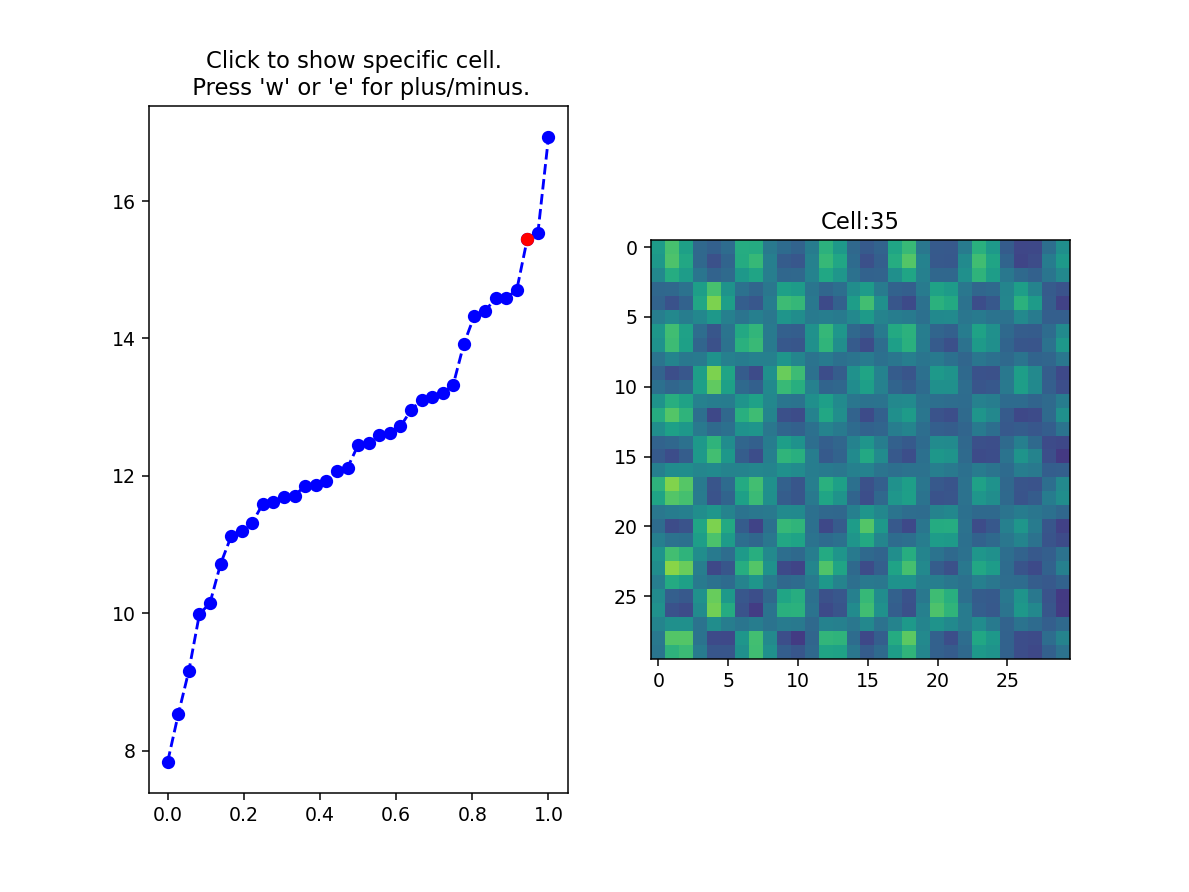

In [43]:
# Plotting first L2 norm to estimate ratio which should be excluded

# Normalize images
darkfield_aligned_norm = (darkfield_aligned-np.amin(darkfield_aligned))/(np.amax(darkfield_aligned)-np.amin(darkfield_aligned))
darkfield_aligned_averaged_norm = (darkfield_aligned_averaged-np.amin(darkfield_aligned_averaged))/(np.amax(darkfield_aligned_averaged)-np.amin(darkfield_aligned_averaged))

# Calculate L2 norm
L2_norm = []
for i, cell in enumerate(np.moveaxis(darkfield_aligned_norm,2,0)):
    L2_norm.append(np.sum(np.square(darkfield_aligned_averaged_norm-cell)))

    
# Plotting results    
class Selector():
    def __init__(self,darkfield_aligned_norm,L2_norm):
        self.darkfield_aligned_norm = darkfield_aligned_norm
        self.L2_norm = L2_norm
        self.x_points = np.linspace(0,1,self.darkfield_aligned_norm.shape[2])
        
        # Set initial index
        self.idx = 0
        # Differentiate between click and drag (for zooming)
        self.MAX_CLICK_LENGTH = 0.2
        
        # Plot
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2)

        # Calculate axes for L2-norm
        self.L2_sorted = np.sort(self.L2_norm)
        
        # Plot L2-norm
        self.lineplot = self.ax1.plot(self.x_points,self.L2_sorted, linestyle='--', marker='o', color='b', zorder=0)
        self.scatter_2, = self.ax1.plot(self.x_points[self.idx],self.L2_sorted[self.idx] , marker='o', color='r')
        
        # Set titles
        self.ax1.set_title("Click to show specific cell. \n Press 'w' or 'e' for plus/minus.")
        self.ax2.set_title('Cell:' + str(self.idx + 1))

        # Plot cells (initialize with first cell)
        self.l2_plot = self.ax2.imshow(self.darkfield_aligned_norm[:,:,self.idx])
        self.l2_plot.set_clim(vmin=0, vmax=1)

        # Connect
        self.cid = self.ax1.figure.canvas.mpl_connect("button_press_event",self.select_change_press)
        self.cid = self.ax1.figure.canvas.mpl_connect("button_release_event",self.select_change_release)
        self.cid = self.ax1.figure.canvas.mpl_connect("key_press_event",self.select_change_key)
        
    def select_change_press(self, event):
        self.time_onclick = time.time()
        
        return

    def select_change_release(self, event):  
        if (time.time() - self.time_onclick) < self.MAX_CLICK_LENGTH:
            # Get position of mouse
            x = event.xdata

            # Find nearest point
            array = np.asarray(self.x_points)
            self.idx = (np.abs(array - x)).argmin()

            # Plot
            self.plot()
        else:
            pass
        
        return
    
    def select_change_key(self, event):   
        # Detect key
        if event.key == "w":
            self.idx -= 1
        elif event.key == "e":
            self.idx += 1
        
        # Reset idx,if out of boundary
        if self.idx < 0:
            self.idx = 0
        elif self.idx > self.darkfield_aligned_norm.shape[2]-1:
            self.idx = self.darkfield_aligned_norm.shape[2]-1

        # Plot
        self.plot()
        
        return
    
    def plot(self):
        # Set new cell
        self.l2_plot.set_data(self.darkfield_aligned_norm[:,:,self.idx])
        
        # Set new point
        self.scatter_2.set_data(self.x_points[self.idx],self.L2_sorted[self.idx])
        
        # Set new title
        self.ax2.set_title('Cell:' + str(self.idx + 1))

        # Update figure
        self.fig.canvas.draw_idle()
        
        return
        
L2_selector = Selector(darkfield_aligned_norm,L2_norm)
plt.show()

In [44]:
# Percentage of images, which should be kept
print("Enter the ratio of cells, which should be kept.")
n_ratio = float(input())

Enter the ratio of cells, which should be kept.
0.9


Number of total slices: 37
Number of slices after L2-norm: 33


<IPython.core.display.Javascript object>


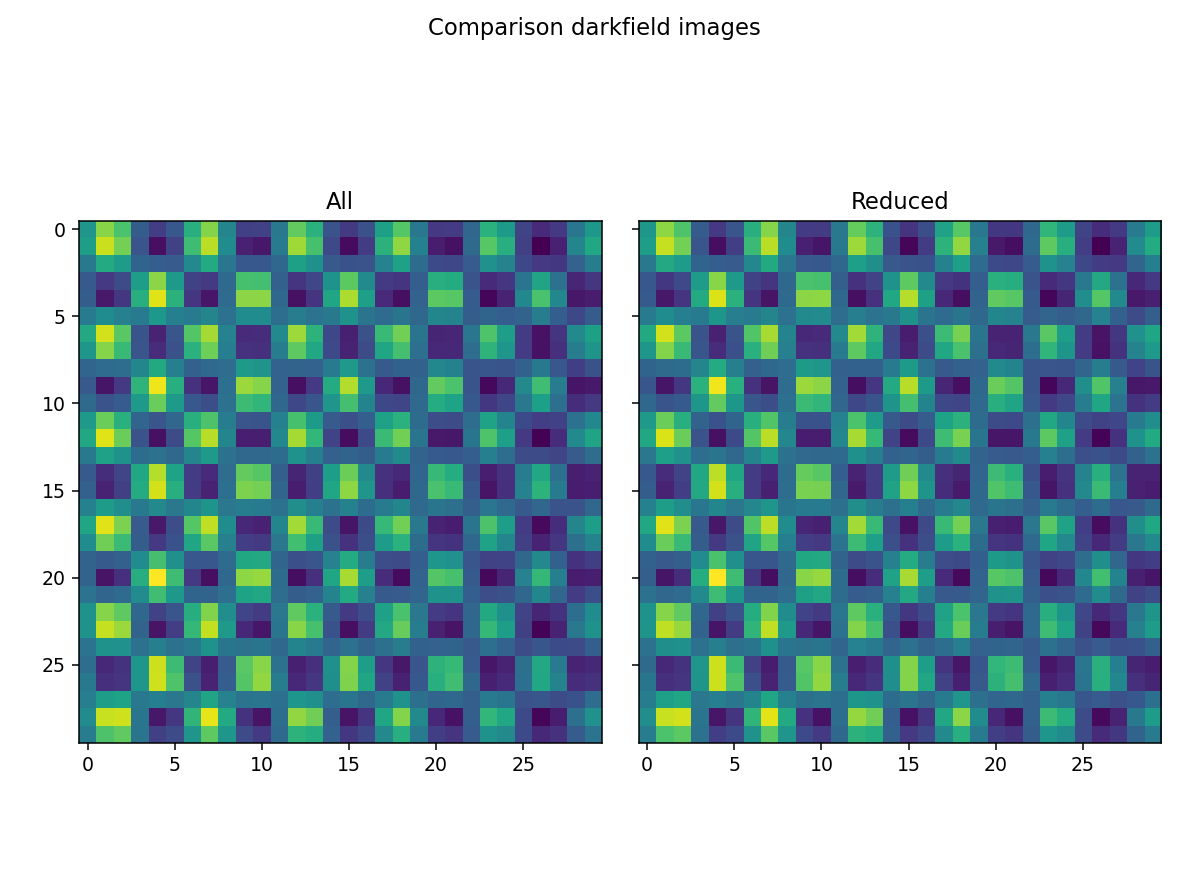

In [45]:
# Number of images, which are removed
n_abs = np.round(darkfield_aligned_norm.shape[2]*(1-n_ratio)).astype(np.int32)

# Stacks, where the slices will be thrown out
darkfield_aligned_norm_L2 = darkfield_aligned_norm
index_image_stack_L2 = index_image_stack.copy()
translation_matrix_x_L2 = translation_matrix_x
translation_matrix_y_L2 = translation_matrix_y

for i in range(0,n_abs):
    # Remove slice with the largest L2 norm
    i_remove = np.argsort(L2_norm)[-1]
    
    # Remove slice from all stacks
    darkfield_aligned_norm_L2 = np.delete(darkfield_aligned_norm_L2,i_remove,axis=2)
    translation_matrix_x_L2 = np.delete(translation_matrix_x_L2,i_remove,axis=2)
    translation_matrix_y_L2 = np.delete(translation_matrix_y_L2,i_remove,axis=2)
    del index_image_stack_L2[i_remove]
    
    # New averaged image
    darkfield_aligned_averaged_norm_L2 = np.sum(darkfield_aligned_norm_L2, axis=2)
    darkfield_aligned_averaged_norm_L2 = (darkfield_aligned_averaged_norm_L2-np.amin(darkfield_aligned_averaged_norm_L2))/(np.amax(darkfield_aligned_averaged_norm_L2)-np.amin(darkfield_aligned_averaged_norm_L2))
    
    # Calculate new L2 norm
    L2_norm = []
    for i, cell in enumerate(np.moveaxis(darkfield_aligned_norm_L2,2,0)):
        L2_norm.append(np.sum(np.square(darkfield_aligned_averaged_norm_L2-cell)))

        
print('Number of total slices: ' + str(darkfield_aligned_norm.shape[2]))
print('Number of slices after L2-norm: ' + str(darkfield_aligned_norm.shape[2]-n_abs))

# Plotting results

# Average image if new cells are removed
darkfield_aligned_averaged_norm_L2 = np.sum(darkfield_aligned_norm_L2, axis=2)
darkfield_aligned_averaged_norm_L2 = (darkfield_aligned_averaged_norm_L2-np.amin(darkfield_aligned_averaged_norm_L2))/(np.amax(darkfield_aligned_averaged_norm_L2)-np.amin(darkfield_aligned_averaged_norm_L2))


# Compare new averaged image and the old one
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.suptitle('Comparison darkfield images')
ax2.imshow(darkfield_aligned_averaged_norm_L2)
ax2.set_title('Reduced')

ax1.imshow(darkfield_aligned_averaged_norm)
ax1.set_title('All')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## Averaging EELS Stack
After the darkfield stack is cropped, stacked, aligned and reduced by the L2-norm, this will be now performed to the spectrum image. (Due to the large spectrum images this is not done before to save computional cost)

Like SmartAlign, the same function for moving the pixels will be used.

In [46]:
# Move2d_pixel_double from matlab
def movepixels_2d_double(Iin,Tx,Ty,mode, height, width):

    # Make all x,y indices
    x, y = np.meshgrid(np.arange(0, height),np.arange(0, width), indexing='ij')

    # Calculate the Transformed coordinates
    Tlocalx = x + Tx
    Tlocaly = y + Ty

    # All the neighborh pixels involved in linear interpolation.
    xBas0 = np.floor(Tlocalx)
    yBas0 = np.floor(Tlocaly)
    xBas1 = xBas0 + 1     
    yBas1 = yBas0 + 1

    # Linear interpolation constants (percentages)
    xCom = Tlocalx - xBas0
    yCom = Tlocaly - yBas0
    perc0 = (1 - xCom) * (1 - yCom)
    perc1 = (1 - xCom) * yCom
    perc2 = xCom * (1 - yCom)
    perc3 = xCom * yCom

    # limit indexes to boundaries
    check_xBas0 = (xBas0 < 0) | (xBas0 > (Iin.shape[0]-1))
    check_yBas0 = (yBas0 < 0) | (yBas0 > (Iin.shape[1]-1))
    xBas0[check_xBas0] = 0 
    yBas0[check_yBas0] = 0 
    check_xBas1 = (xBas1 < 0) | (xBas1 > (Iin.shape[0]-1))
    check_yBas1 = (yBas1 < 0) | (yBas1 > (Iin.shape[1]-1))
    xBas1[check_xBas1] = 0 
    yBas1[check_yBas1] = 0 


    Iout = np.zeros(Iin.shape)
    for i in range(0,Iin.shape[2]):    
        Iin_one = Iin[:,:,i]
        # Get the intensities
        intensity_xyz0 = np.reshape(Iin_one.flatten(order="F")[(xBas0 + yBas0 * Iin.shape[0]).astype(np.int32)],(height, width))
        intensity_xyz1 = np.reshape(Iin_one.flatten(order="F")[(xBas0 + yBas1 * Iin.shape[0]).astype(np.int32)],(height, width))
        intensity_xyz2 = np.reshape(Iin_one.flatten(order="F")[(xBas1 + yBas0 * Iin.shape[0]).astype(np.int32)],(height, width))
        intensity_xyz3 = np.reshape(Iin_one.flatten(order="F")[(xBas1 + yBas1 * Iin.shape[0]).astype(np.int32)],(height, width))
        
        # Make pixels before outside Ibuffer mode
        if mode==1 and mode==3:
            intensity_xyz0[check_xBas0 | check_yBas0] = 0
            intensity_xyz1[check_xBas0 | check_yBas1] = 0
            intensity_xyz2[check_xBas1 | check_yBas0] = 0
            intensity_xyz3[check_xBas1 | check_yBas1] = 0
        
        # Calculate new intensities and reshape to original data
        Iout_one = intensity_xyz0 * perc0 + intensity_xyz1 * perc1 + intensity_xyz2 * perc2 + intensity_xyz3 * perc3 
        Iout[:,:,i] = np.reshape(Iout_one, (Iin.shape[0],Iin.shape[1]), order="F")

    return Iout

In [47]:
# Align and average spectrum image

EELS_sum = np.zeros((height, width, EELS_data.shape[2]))

# Interpolation mode
mode = 0

# Aligning EELS data
for i, cell_index in enumerate(tqdm_notebook(index_image_stack_L2)):
    # Crop EELS data
    EELS_slice = EELS_data[cell_index[0]:cell_index[0]+height,cell_index[1]:cell_index[1]+width,:]

    # Perform translation like smart align with movepixels_2d
    Tx = translation_matrix_x_L2[:,:,i]
    Ty = translation_matrix_y_L2[:,:,i]

    # Applying transformation for every energy channel
    EELS_sum += movepixels_2d_double(EELS_slice,Tx,Ty,mode, height, width)

# Average EELS spectra
EELS_sum = EELS_sum/darkfield_aligned_norm_L2.shape[2]

  0%|          | 0/33 [00:00<?, ?it/s]

## PCA Denoising
After averaging the spectrum image is further denoised by PCA. Due to the risk of PCA of removing important information or introducing artefact, interactive mapping will be applied to be able to compare fast different number of components.

Linear combination of powerlaw and local background averaging approach from https://doi.org/10.1017/S1431927612000244

In [48]:
# Generate a hyperspy-class from the average spectrum image to apply the PCA
s_averaged_orig = hs.signals.Signal1D(EELS_sum)
# Adjust axes
s_averaged_orig.axes_manager = s_EELS.axes_manager
s_averaged_orig.axes_manager['x'].size = width
s_averaged_orig.axes_manager['y'].size = height

In [49]:
# Average whole averaged spectrum image for setting signal and background range
s = hs.signals.Signal1D(np.sum(EELS_sum,axis=(0,1)))
# Adjust axes
s.axes_manager[0].name = s_averaged_orig.axes_manager[2].name
s.axes_manager[0].scale = s_averaged_orig.axes_manager[2].scale
s.axes_manager[0].offset = s_averaged_orig.axes_manager[2].offset
s.axes_manager[0].size = s_averaged_orig.axes_manager[2].size

# Span initial region of interest
roi_1 = hs.roi.SpanROI(left=s.axes_manager[0].offset, right=s.axes_manager[0].offset + s.axes_manager[0].scale*s.axes_manager[0].size/4)
roi_2 = hs.roi.SpanROI(left=s.axes_manager[0].offset + s.axes_manager[0].scale*s.axes_manager[0].size/3, right=s.axes_manager[0].offset + s.axes_manager[0].scale*s.axes_manager[0].size*2/4)

<IPython.core.display.Javascript object>


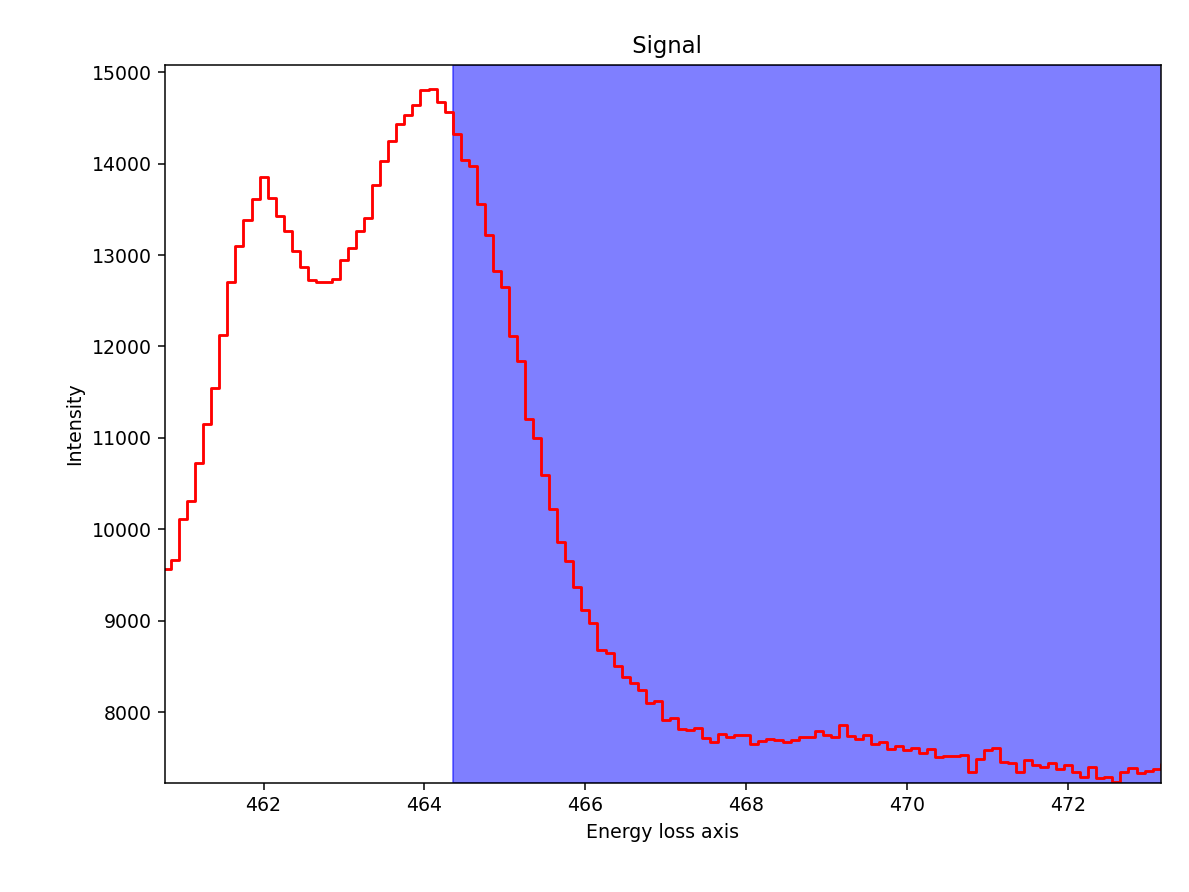

blue: Background
green: Signal


In [73]:
# Select background for removal and signal for integration
s.plot()

print('blue: Background')
print('green: Signal')

# Get values for the background and signal
roi_1.interactive(s, color='blue')
roi_2.interactive(s, color='green')

# Reset EELS data if background is changed
s_averaged = copy.deepcopy(s_averaged_orig)

Background: 62.9 eV from 464.4 eV to 527.3 eV
Signal: 1.2 eV from 529.8 eV to 531.0 eV


<IPython.core.display.Javascript object>


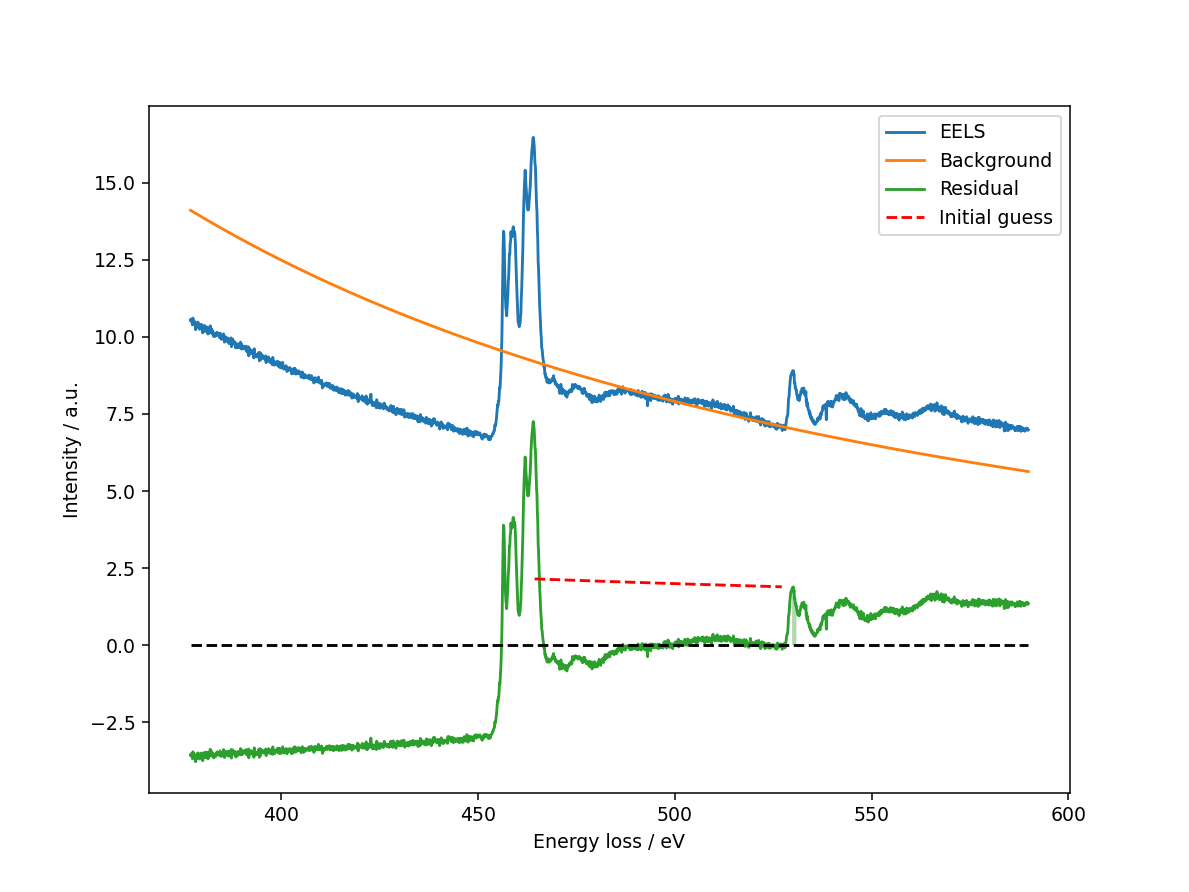

Text(0, 0.5, 'Intensity / a.u.')

In [74]:
# Choose between powerlaw and exponential (double --> linear combination can be used later)
case = 'Powerlaw'

# Define background function
def powerlaw(x, A, r):
    return A * x**(-r)
def exponetial(x, A, r):
    return A * np.exp(-r*x)

# Define initial parameters and creating the fitting model, depending on the function
if case == 'Powerlaw':
    # Create fitting model
    gmodel = Model(powerlaw)
    
    # Add required parameters (incl. constraints)
    params = Parameters()
    params.add('A', value=1000, min=0, max=np.inf, vary = True)
    params.add('r', value=1, min=0, max=np.inf, vary = True)

elif case == 'Exponential':
    # Create fitting model
    gmodel = Model(exponetial)
    
    # Add required parameters (incl. constraints)
    params = Parameters()
    params.add('A', value=450, min=0, max=np.inf, vary = True)
    params.add('r', value=0.01, min=0, max=np.inf, vary = True)

# Calculate x-axes vector
x_axes_background = np.arange(roi_1.left, roi_1.right, s.axes_manager[0].scale)
x_axes_signal = np.arange(roi_2.left, roi_2.right, s.axes_manager[0].scale)
x_axes = np.arange(s.axes_manager[0].offset, s.axes_manager[0].offset + s.axes_manager[0].scale*s.axes_manager[0].size, s.axes_manager[0].scale)

# Crop spectrum to background roi
s_fit = s.isig[roi_1].data/(EELS_sum.shape[0]*EELS_sum.shape[1])
# Fit averaged spectrum to get better estimation for initial parameters for each pixel
result = gmodel.fit(s_fit, params, x=x_axes_background)

# Selected energy ranges
print('Background: ' + str(np.around(roi_1.right - roi_1.left,decimals = 2)) + ' eV from ' + str(np.around(roi_1.left,decimals = 2)) + ' eV to ' + str(np.around(roi_1.right,decimals = 2)) + ' eV')
print('Signal: ' + str(np.around(roi_2.right - roi_2.left,decimals = 2)) + ' eV from ' + str(np.around(roi_2.left,decimals = 2)) + ' eV to ' + str(np.around(roi_2.right,decimals = 2)) + ' eV')


# Plot signal and fitted background
figure, ax = plt.subplots(1, 1)
ax.plot(x_axes,s.data/(EELS_sum.shape[0]*EELS_sum.shape[1]), label = 'EELS')
ax.plot(x_axes,gmodel.eval(result.params, x=x_axes), label = 'Background')
ax.plot(x_axes,s.data/(EELS_sum.shape[0]*EELS_sum.shape[1])-gmodel.eval(result.params, x=x_axes), label = 'Residual')
ax.fill_between(x_axes_signal,s.isig[roi_2].data/(EELS_sum.shape[0]*EELS_sum.shape[1])-gmodel.eval(result.params, x=x_axes_signal), alpha = 0.3, facecolor = 'green')
ax.plot([np.amin(x_axes), np.amax(x_axes)],[0, 0],'k--')
ax.plot(x_axes_background,result.init_fit,'r--', label = 'Initial guess')
ax.legend()
ax.set_xlabel('Energy loss / eV')
ax.set_ylabel('Intensity / a.u.')

Result already exist! Overwrite files? [y/n]y
Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


<IPython.core.display.Javascript object>


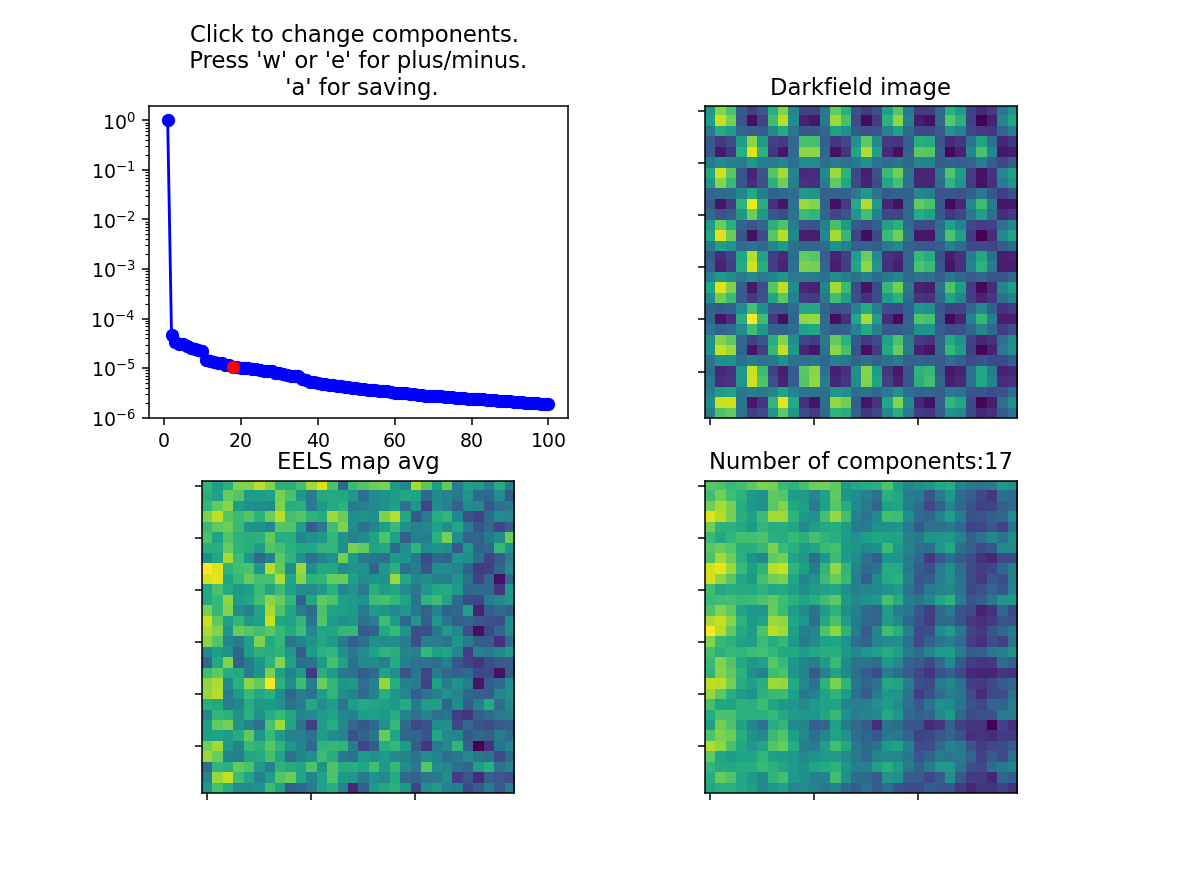

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [75]:
# Choose if the background should removed before PCA denoising (if true background is removed first)
background_removal_pca = False

# Average d next nearest neighbours for local background averaging
d = 1

# Reset EELS data
s_averaged = copy.deepcopy(s_averaged_orig)

if background_removal_pca:
    background = 'first'
else:
    background = 'second'

# Plotting and saving results    
class Selector_pca():
    def __init__(self,s_averaged, roi_1, roi_2, darkfield_aligned_averaged_norm, path, background, para_init, d, gmodel):
        # Initialize variables
        self.s_averaged = s_averaged
        self.roi_1 = roi_1
        self.roi_2 = roi_2
        self.darkfield_aligned_averaged_norm = darkfield_aligned_averaged_norm
        self.path = path
        self.background = background
        self.para_init = para_init
        self.d = d
        self.gmodel = gmodel

        
        # Initial index
        self.idx = 1
        # Differentiate between click and drag for zooming
        self.MAX_CLICK_LENGTH = 0.2
        
        # Background subtraction
        if background == 'first':
            self.s_b, self.r = background_subtraction(self.gmodel, self.s_pca, self.roi_1, self.para_init, self.d)
        else:
            self.s_b = self.s_averaged   
        
        # Poisson distribution does not allow negative values
        if poisson_noise:
            self.s_b.data[self.s_b.data < 0] = 0

        # Decompose (if background is not removed, it has to be removed after selecting the number of components)
        self.s_b.decomposition(normalize_poissonian_noise=poisson_noise)
        
        
        ## Initialize plots
        self.fig, ((self.ax1, self.ax2), (self.ax3, self.ax4)) = plt.subplots(2, 2)
        
        # Share axes (for zooming)
        self.ax2.get_shared_x_axes().join(self.ax2, self.ax3)
        self.ax2.get_shared_x_axes().join(self.ax2, self.ax4)       
        self.ax2.get_shared_y_axes().join(self.ax2, self.ax3)
        self.ax2.get_shared_y_axes().join(self.ax2, self.ax4)    
        
        # Set ticks off
        self.ax2.set_xticklabels([])
        self.ax2.set_yticklabels([])
        self.ax3.set_xticklabels([])
        self.ax3.set_yticklabels([])
        self.ax4.set_xticklabels([])
        self.ax4.set_yticklabels([])
        
        # Set titles
        self.ax1.set_title("Click to change components. \n Press 'w' or 'e' for plus/minus. \n 'a' for saving.")
        self.ax2.set_title('Darkfield image')
        self.ax3.set_title('EELS map avg')
        self.ax4.set_title('Number of components:' + str(self.idx))
        
        ## Plot ax1
        
        # Get PCA components variance
        self.variance_pca = self.s_b.get_explained_variance_ratio().data[:100]
        self.x_scree = np.arange(1,len(self.variance_pca)+1)
        
        # Plot scree plot
        self.lineplot = self.ax1.plot(self.x_scree,self.variance_pca, marker='o', color='b', zorder=0)
        self.scatter_2, = self.ax1.plot(self.x_scree[self.idx], self.variance_pca[self.idx] , marker='o', color='r')
        self.ax1.set_yscale('log')

        
        ## Plot ax2
        
        # Plot darkfield image
        self.ax2.imshow(self.darkfield_aligned_averaged_norm)
        
        
        ## Plot ax3
        
        # Plot EELS map from averaged EELS signal
        if background == 'second':
            self.s_avg = self.background_subtraction(self.gmodel, self.s_b, self.roi_1, self.para_init, self.d)
        else:
            self.s_avg = self.s_b
        self.s_avg_signal = self.s_avg.isig[self.roi_2].integrate1D(-1)
        self.s_avg_arr =self.normalize(self.s_avg_signal)
        
        # Save
        Image.fromarray(self.s_avg_arr).save(path + '\\Signal_Averaged_Integrate_(' + str(np.around(self.roi_2.left,decimals = 2)) + '-' + str(np.around(self.roi_2.right,decimals = 2)) + ')_Background_(' + str(np.around(self.roi_1.left,decimals = 2)) + '-' + str(np.around(self.roi_1.right,decimals = 2)) + ')_Background_' + self.background + '.tiff')    

        # Plot averaged EELS map
        self.ax3.imshow(self.s_avg_arr) 
       
        
        ## Plot ax4
        
        # Denoise spectra
        self.s_b_pca = self.s_b.get_decomposition_model(int(self.idx))
        # Background subtraction
        if background == 'second':
            self.s_pca_b = self.background_subtraction(self.gmodel, self.s_b_pca, self.roi_1, self.para_init, self.d)
        else:
            self.s_pca_b = self.s_b_pca
        self.s_pca_signal =  self.s_pca_b.isig[self.roi_2].integrate1D(-1)   
        self.s_pca_s_arr = self.normalize(self.s_pca_signal)
        
        self.p_pca_s_arr = self.ax4.imshow(self.s_pca_s_arr)
      
        
        # mpl_connect (press & release to distinguish between clicking and dragging)
        self.cid1 = self.ax1.figure.canvas.mpl_connect("button_press_event",self.select_change_press)
        self.cid2 = self.ax1.figure.canvas.mpl_connect("button_release_event",self.select_change_release)
        self.cid3 = self.ax1.figure.canvas.mpl_connect("key_press_event",self.select_change_key)
        
    def select_change_press(self, event):
        # Start timer
        self.time_onclick = time.time()
        
        return

    def select_change_release(self, event):  
        # If mouse is released before MAX_CLICK_LENGTH duration --> click, otherwise dragging
        if (time.time() - self.time_onclick) < self.MAX_CLICK_LENGTH:
            # Get position of mouse
            x = event.xdata

            # Find nearest point
            array = np.asarray(self.x_scree)
            self.idx = (np.abs(array - x)).argmin()

            # Start plot function
            self.plot()
        else:
            pass
        
        return
    
    def select_change_key(self, event):   
        # Detect key
        if event.key == "w":
            self.idx -= 1
        elif event.key == "e":
            self.idx += 1
        elif event.key == "a":
            # Save results PCA single background
            Image.fromarray(self.signal_arr).save(self.path + '\\Signal_PCA_denoised_n_' + str(int(self.idx)) + '_Integrate_(' + str(np.around(roi_2.left,decimals = 2)) + '-' + str(np.around(roi_2.right,decimals = 2)) + ')_Background_(' + str(np.around(roi_1.left,decimals = 2)) + '-' + str(np.around(roi_1.right,decimals = 2)) + ')_Background_' + self.background + '.tiff')
            return              

        
        # Reset idx,if out of boundary
        if self.idx < 0:
            self.idx = 0
        elif self.idx > self.x_scree[-1]-1:
            self.idx = self.x_scree[-1]-1

        # Plot
        self.plot()
        
        return
    
    def plot(self):
        
        # Calculate new signal
        self.s_pca = self.s_b.get_decomposition_model(int(self.idx))
        # Background subtraction
        if self.background == 'second':
            self.s_pca_b = self.background_subtraction(self.gmodel, self.s_pca, self.roi_1, self.para_init, self.d)
        else:
            self.s_pca_b = self.s_pca
        # Integrate
        self.signal = self.s_pca_b.isig[self.roi_2].integrate1D(-1)
        # Normalize and set new plot data
        self.signal_arr = self.normalize(self.signal)
        self.p_pca_s_arr.set_data(self.signal_arr)
        
        # Set new point
        self.scatter_2.set_data(self.x_scree[self.idx],self.variance_pca[self.idx])
        
        # Set new title
        self.ax4.set_title('Number of components:' + str(self.idx))

        # Update figure
        self.fig.canvas.draw_idle()
        
        return
    
    def normalize(self, s):
        s_arr = s.data
        return (s_arr-np.amin(s_arr))/(np.amax(s_arr)-np.amin(s_arr))
    
    # Function for fitting the background with local background averaging (and linear combination of powerlaws) --> returns the signal
    def background_subtraction(self, gmodel, s_hs, roi_background, para_init, d = 0):
        s_shape = s_hs.data.shape

        # x-vector for background fitting
        x_axes_b = np.arange(roi_background.left, roi_background.right, s_hs.axes_manager[-1].scale)
        x_axes = np.arange(s_hs.axes_manager[-1].offset, s_hs.axes_manager[-1].offset + s_hs.axes_manager[-1].scale*s_hs.axes_manager[-1].size, s_hs.axes_manager[-1].scale)

        # Crop signal for background fitting
        s_fit = s_hs.isig[roi_background].data

        # Flatten spectrum image for easier indexing
        s_flatten = s_fit.reshape(-1, s_fit.shape[-1])

        # Array, which saves signal
        s_residual = np.zeros(s_shape)

        for i in tqdm_notebook(range(0,s_shape[0])):
            for j in range(0,s_shape[1]):
                # Get average EELS spectrum from d-neighbors
                s_summed = self.cell_neighbors(s_flatten, s_shape, i, j, d=d)
                # Fit background for averaged EELS spectrum
                results = gmodel.fit(s_summed, params = para_init, x=x_axes_b)
                # Subtract background from the signal
                background_fitted = gmodel.eval(results.params, x=x_axes)
                s_residual[i,j,:] = s_hs.data[i,j,:] - background_fitted

        s_residuals = copy.deepcopy(s_hs)
        s_residuals.data = s_residual

        return s_residuals

    # Following two function are used for local background averaging 
    def sliding_window(self, arr, window_size):
        """ Construct a sliding window view of the array"""
        arr = np.asarray(arr)
        window_size = int(window_size)
        if arr.ndim != 2:
            raise ValueError("need 2-D input")
        if not (window_size > 0):
            raise ValueError("need a positive window size")
        shape = (arr.shape[0] - window_size + 1,
                 arr.shape[1] - window_size + 1,
                 window_size, window_size)
        if shape[0] <= 0:
            shape = (1, shape[1], arr.shape[0], shape[3])
        if shape[1] <= 0:
            shape = (shape[0], 1, shape[2], arr.shape[1])
        strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
                   arr.shape[1]*arr.itemsize, arr.itemsize)
        return as_strided(arr, shape=shape, strides=strides)

    def cell_neighbors(self, s_flatten,s_shape, i, j, d):
        """Return d-th neighbors of cell (i, j)"""
        arr = np.arange(s_shape[0]*s_shape[1]).reshape(s_shape[0], s_shape[1])
        w = self.sliding_window(arr, 2*d+1)

        ix = np.clip(i - d, 0, w.shape[0]-1)
        jx = np.clip(j - d, 0, w.shape[1]-1)

        i0 = max(0, i - d - ix)
        j0 = max(0, j - d - jx)
        i1 = w.shape[2] - max(0, d - i + ix)
        j1 = w.shape[3] - max(0, d - j + jx)

        elements = w[ix, jx][i0:i1,j0:j1].ravel()

        s_sum = np.sum(s_flatten[elements,:],axis=0)/(len(elements))

        return s_sum

    
# Location of saving results
path = os.path.dirname(os.path.abspath(filename_EELS)) + '\\Post_Processing'
    
 # If folder is already present, ask to overwrite files
if not os.path.exists(path):          
    os.mkdir(path)
    # Save dark field image
    Image.fromarray(darkfield_aligned_averaged_norm_L2).save(path + '\\Darkfield_Averaged.tiff')

    pca_selector = Selector_pca(s_averaged, roi_1, roi_2, darkfield_aligned_averaged_norm,  path, background, result.params, d, gmodel)
    plt.show()

else:
    answer = input('Result already exist! Overwrite files? [y/n]')
    if not answer.lower() in ['y','yes']:
        print('Saving results aborted by user due to existing results!')
    else:
        # Save dark field image
        Image.fromarray(darkfield_aligned_averaged_norm_L2).save(path + '\\Darkfield_Averaged.tiff')

        pca_selector = Selector_pca(s_averaged, roi_1, roi_2, darkfield_aligned_averaged_norm, path, background, result.params, d, gmodel)
        plt.show()

## Saving notebook for documentation
The complete notebook will be saved as pdf for documentation. For this you have to install the package nbconvert.

First the location of the notebook will be extracted with javascript. After this, a command is executed in the windows command prompt. This may cause problems with Linux.

In [ ]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

In [ ]:
# Activate conda with the current environment
path_env = os.path.dirname(os.path.abspath(sys.executable))    
cmd_env = 'conda activate ' + path_env
subprocess.call(cmd_env, shell=True)

# Create pdf-file from the notebook

# Path and name of notebook
ipynb_path = os.path.dirname(os.path.realpath("__file__")) + '\\Post_processing.ipynb' 

# Execute command in windows cmd
cmd = 'jupyter-nbconvert --to PDFviaHTML ' + ipynb_path
subprocess.call(cmd, shell=True)
                                                                         
# Shift the pdf-file to the results folder
source = NOTEBOOK_FULL_PATH[:-5] + 'pdf'
destination = path + '\\Documentation_PostProcessing.pdf'
os.rename(source, destination)